In [1]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import column_or_1d
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier 
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
from time import time

import matplotlib.pyplot as plt
%matplotlib inline 

pd.options.display.max_columns = 1000

## FUNCTIONS 

In [2]:
def fscore(y_pred, y_test):
    """Returns the precision, recall and F1 score"""
    col = ['ASSAULT', 'BATTERY', 'BURGLARY', 'CRIMINAL DAMAGE', 'CRIMINAL TRESPASS', 'DECEPTIVE PRACTICE', 'MOTOR VEHICLE THEFT', 'NARCOTICS', 'OTHER OFFENSE', 'ROBBERY', 'THEFT']
    table = []
    
    #if 'NA' in y_pred.columns:
     #   del y_pred['NA']
        
    for c in col:
        
        act_yes = sum(y_test[c])
        act_no = len(y_test[c]) - act_yes
        
        if c not in y_pred.columns:
            pred_yes = 0
            pred_no = 0
        else:
            pred_yes = sum(y_pred[c])
            pred_no = len(y_pred[c]) - pred_yes
        
        if c not in y_pred.columns:
            tn = 0
            fp = 0
            fn = 0
            tp = 0
        else:
            tn, fp, fn, tp = confusion_matrix(y_test[c], y_pred[c]).ravel()
        
        table.append([c.replace('Primary Type_', ''), tp, fp, tn, fn, act_yes, act_no, pred_yes, pred_no])
    
    df = pd.DataFrame(table)
    df.columns = ['Primary Type of Crime', 'True Positives', 'False Positives', 'True Negatives', 'False Negatives', 'Actual Yes', 'Actual No', 'Predicted Yes', 'Predicted No']
    
    df['Precision'] = df['True Positives'] / df['Predicted Yes']
    df['Recall'] = df['True Positives'] / df['Actual Yes']
    df['F1 Score'] = 2 * (df['Precision'] * df['Recall']) / (df['Precision'] + df['Recall'])
    
    df.fillna(0, inplace=True)
    
    simple_df = pd.DataFrame()
    simple_df['Ave. Precision'] = [np.mean(df['Precision'])]
    simple_df['Ave. Recall'] = [np.mean(df['Recall'])]
    simple_df['F1 Score'] = [np.mean(df['F1 Score'])]
    
    return (df, simple_df)

In [3]:
def rmse(y_pred, y_test):

    col = ['ASSAULT', 'BATTERY', 'BURGLARY', 'CRIMINAL DAMAGE', 'CRIMINAL TRESPASS', 'DECEPTIVE PRACTICE', 'MOTOR VEHICLE THEFT', 'NARCOTICS', 'OTHER OFFENSE', 'ROBBERY', 'THEFT']
    
    #if 'NA' in y_pred.columns:
     #   del y_pred['NA']
        
    for c in col:
        if c not in y_pred.columns:
            y_pred[c] = 0
    
    y_pred = y_pred.reindex(columns=col)    
        
    error = np.sqrt(sum((np.array(y_pred) - np.array(y_test)) ** 2) / len(y_pred)) 
    
    df = pd.DataFrame()
    df['Primary Type'] = col
    df['RMSE'] = error
    
    ave_rmse = np.mean(error)
    
    return (df, ave_rmse)

## Reading X, y

In [4]:
# Reading in sample of reports
X_sample = pd.read_csv('../Model Scripts/X_sample_3mil.csv')
y_sample = pd.read_csv('../Model Scripts/y_sample_3mil.csv', header=None)
y_sample = y_sample[0]
y_sample = column_or_1d(y_sample, warn=True)

In [5]:
X_sample.columns

Index(['Location Description', 'Beat', 'District', 'Ward', 'Community',
       'X Coordinate', 'Y Coordinate', 'Latitude', 'Longitude', 'Month',
       'Season', 'Quarter of Year', 'Day of the Week', 'Day Type',
       'Time of Day', 'Hour', 'Holiday', 'Is Holiday',
       'Distance from Chicago (km)',
       'Distance from Closest Police Station (km)', 'Closest Train Line',
       'Distance from Closest Train Stop (km)',
       'Distance from Closest Bus Stop (km)',
       'Distance from Closest Liquor Store (km)',
       'Square Root of Distance from Closest Police Station (km)',
       'Square Root of Distance from Closest Bus Stop (km)',
       'Square Root of Distance from Closest Liquor Store (km)'],
      dtype='object')

In [6]:
# Grabbing certain columns 
X_sample = X_sample[['Location Description', 'Beat', 'District', 'Ward', 'Community',
       'X Coordinate', 'Y Coordinate', 'Month', 'Season', 'Day of the Week', 'Day Type',
       'Time of Day', 'Hour', 'Holiday', 'Is Holiday', 'Closest Train Line',
       'Distance from Closest Train Stop (km)',
       'Square Root of Distance from Closest Liquor Store (km)', 'Distance from Chicago (km)',
       'Square Root of Distance from Closest Police Station (km)',
       'Square Root of Distance from Closest Bus Stop (km)']]

In [7]:
# Encoding categorical data using get_dummies()
cols = ['Location Description', 'Beat', 'District', 'Ward', 'Community', 
       'Month', 'Season', 'Day of the Week', 'Day Type', 'Time of Day', 
        'Hour', 'Holiday', 'Is Holiday', 'Closest Train Line']
#X_dummy_sample = pd.get_dummies(columns=cols, data=X_sample, drop_first=True)
X_dummy_sample = pd.get_dummies(columns=cols, data=X_sample)

In [8]:
X_dummy_sample.head()

,X Coordinate,Y Coordinate,Distance from Closest Train Stop (km),Square Root of Distance from Closest Liquor Store (km),Distance from Chicago (km),Square Root of Distance from Closest Police Station (km),Square Root of Distance from Closest Bus Stop (km),Location Description_ABANDONED BUILDING,Location Description_AIRCRAFT,Location Description_AIRPORT BUILDING NON-TERMINAL-NON-SECURE AREA,Location Description_AIRPORT BUILDING NON-TERMINAL-SECURE AREA,Location Description_AIRPORT EXTERIOR-NON-SECURE AREA,Location Description_AIRPORT EXTERIOR-SECURE AREA,Location Description_AIRPORT PARKING LOT,Location Description_AIRPORT TERMINAL LOWER LEVEL-NON-SECURE AREA,Location Description_AIRPORT TERMINAL LOWER LEVEL-SECURE AREA,Location Description_AIRPORT TERMINAL MEZZANINE-NON-SECURE AREA,Location Description_AIRPORT TERMINAL UPPER LEVEL-NON-SECURE AREA,Location Description_AIRPORT TERMINAL UPPER LEVEL-SECURE AREA,Location Description_AIRPORT TRANSPORTATION SYSTEM (ATS),Location Description_AIRPORT VENDING ESTABLISHMENT,Location Description_AIRPORT/AIRCRAFT,Location Description_ALLEY,Location Description_ANIMAL HOSPITAL,Location Description_APARTMENT,Location Description_APPLIANCE STORE,Location Description_ATHLETIC CLUB,Location Description_ATM (AUTOMATIC TELLER MACHINE),Location Description_AUTO/BOAT/RV DEALERSHIP,Location Description_BANK,Location Description_BAR OR TAVERN,Location Description_BARBERSHOP,Location Description_BOAT/WATERCRAFT,Location Description_BOWLING ALLEY,Location Description_BRIDGE,Location Description_CAR WASH,Location Description_CEMETARY,Location Description_CHA APARTMENT,Location Description_CHA HALLWAY/STAIRWELL/ELEVATOR,Location Description_CHA PARKING LOT/GROUNDS,Location Description_CHURCH/SYNAGOGUE/PLACE OF WORSHIP,Location Description_CLEANING STORE,Location Description_COIN OPERATED MACHINE,Location Description_COLLEGE/UNIVERSITY GROUNDS,Location Description_COLLEGE/UNIVERSITY RESIDENCE HALL,Location Description_COMMERCIAL/BUSINESS OFFICE,Location Description_CONSTRUCTION SITE,Location Description_CONVENIENCE STORE,Location Description_CREDIT UNION,Location Description_CTA BUS,Location Description_CTA BUS STOP,Location Description_CTA GARAGE/OTHER PROPERTY,Location Description_CTA PLATFORM,Location Description_CTA STATION,Location Description_CTA TRACKS-RIGHT OF WAY,Location Description_CTA TRAIN,Location Description_CURRENCY EXCHANGE,Location Description_DAY CARE CENTER,Location Description_DELIVERY TRUCK,Location Description_DEPARTMENT STORE,Location Description_DRIVEWAY-RESIDENTIAL,Location Description_DRUG STORE,Location Description_FACTORY/MANUFACTURING BUILDING,Location Description_FARM,Location Description_FEDERAL BUILDING,Location Description_FIRE STATION,Location Description_FOREST PRESERVE,Location Description_GAS STATION,Location Description_GOVERNMENT BUILDING/PROPERTY,Location Description_GROCERY FOOD STORE,Location Description_HIGHWAY/EXPRESSWAY,Location Description_HORSE STABLE,Location Description_HOSPITAL BUILDING/GROUNDS,Location Description_HOTEL/MOTEL,Location Description_JAIL/LOCK-UP FACILITY,Location Description_LAKEFRONT/WATERFRONT/RIVERBANK,Location Description_LIBRARY,Location Description_MEDICAL/DENTAL OFFICE,Location Description_MOVIE HOUSE/THEATER,Location Description_NEWSSTAND,Location Description_NURSING HOME/RETIREMENT HOME,Location Description_OTHER,Location Description_OTHER COMMERCIAL TRANSPORTATION,Location Description_OTHER RAILROAD PROP/TRAIN DEPOT,Location Description_PARK PROPERTY,Location Description_PARKING LOT/GARAGE(NON.RESID.),Location Description_PAWN SHOP,Location Description_POLICE FACILITY/VEH PARKING LOT,Location Description_POOL ROOM,Location Description_RESIDENCE,Location Description_RESIDENCE PORCH/HALLWAY,Location Description_RESIDENCE-GARAGE,Location Description_RESIDENTIAL YARD (FRONT/BACK),Location Description_RESTAURANT,Location Description_SAVINGS AND LOAN,"Location Description_SCHOOL, PRIVATE, BUILDING","Location Description_SCHOOL, PRIVATE, 

In [9]:
# Creating train/test data
X_train, X_test, y_train, y_test = train_test_split(X_dummy_sample, y_sample, test_size=0.25, random_state = 23)    # Setting testing and training data

## Scaling Data

In [10]:
# Creating train/test data and scaling all features
X_train, X_test, y_train, y_test = train_test_split(X_dummy_sample, y_sample, test_size=0.25, random_state = 23)    # Setting testing and training data
scaler = MinMaxScaler()
scaled_Xtrain = scaler.fit_transform(X_train)
scaled_Xtest = scaler.transform(X_test)

MinMaxScaler looks like the best way to go as it won't affect my dummy variables so I can scale everything together and not have to separate my features. 

In [11]:
X_train[:5]

,X Coordinate,Y Coordinate,Distance from Closest Train Stop (km),Square Root of Distance from Closest Liquor Store (km),Distance from Chicago (km),Square Root of Distance from Closest Police Station (km),Square Root of Distance from Closest Bus Stop (km),Location Description_ABANDONED BUILDING,Location Description_AIRCRAFT,Location Description_AIRPORT BUILDING NON-TERMINAL-NON-SECURE AREA,Location Description_AIRPORT BUILDING NON-TERMINAL-SECURE AREA,Location Description_AIRPORT EXTERIOR-NON-SECURE AREA,Location Description_AIRPORT EXTERIOR-SECURE AREA,Location Description_AIRPORT PARKING LOT,Location Description_AIRPORT TERMINAL LOWER LEVEL-NON-SECURE AREA,Location Description_AIRPORT TERMINAL LOWER LEVEL-SECURE AREA,Location Description_AIRPORT TERMINAL MEZZANINE-NON-SECURE AREA,Location Description_AIRPORT TERMINAL UPPER LEVEL-NON-SECURE AREA,Location Description_AIRPORT TERMINAL UPPER LEVEL-SECURE AREA,Location Description_AIRPORT TRANSPORTATION SYSTEM (ATS),Location Description_AIRPORT VENDING ESTABLISHMENT,Location Description_AIRPORT/AIRCRAFT,Location Description_ALLEY,Location Description_ANIMAL HOSPITAL,Location Description_APARTMENT,Location Description_APPLIANCE STORE,Location Description_ATHLETIC CLUB,Location Description_ATM (AUTOMATIC TELLER MACHINE),Location Description_AUTO/BOAT/RV DEALERSHIP,Location Description_BANK,Location Description_BAR OR TAVERN,Location Description_BARBERSHOP,Location Description_BOAT/WATERCRAFT,Location Description_BOWLING ALLEY,Location Description_BRIDGE,Location Description_CAR WASH,Location Description_CEMETARY,Location Description_CHA APARTMENT,Location Description_CHA HALLWAY/STAIRWELL/ELEVATOR,Location Description_CHA PARKING LOT/GROUNDS,Location Description_CHURCH/SYNAGOGUE/PLACE OF WORSHIP,Location Description_CLEANING STORE,Location Description_COIN OPERATED MACHINE,Location Description_COLLEGE/UNIVERSITY GROUNDS,Location Description_COLLEGE/UNIVERSITY RESIDENCE HALL,Location Description_COMMERCIAL/BUSINESS OFFICE,Location Description_CONSTRUCTION SITE,Location Description_CONVENIENCE STORE,Location Description_CREDIT UNION,Location Description_CTA BUS,Location Description_CTA BUS STOP,Location Description_CTA GARAGE/OTHER PROPERTY,Location Description_CTA PLATFORM,Location Description_CTA STATION,Location Description_CTA TRACKS-RIGHT OF WAY,Location Description_CTA TRAIN,Location Description_CURRENCY EXCHANGE,Location Description_DAY CARE CENTER,Location Description_DELIVERY TRUCK,Location Description_DEPARTMENT STORE,Location Description_DRIVEWAY-RESIDENTIAL,Location Description_DRUG STORE,Location Description_FACTORY/MANUFACTURING BUILDING,Location Description_FARM,Location Description_FEDERAL BUILDING,Location Description_FIRE STATION,Location Description_FOREST PRESERVE,Location Description_GAS STATION,Location Description_GOVERNMENT BUILDING/PROPERTY,Location Description_GROCERY FOOD STORE,Location Description_HIGHWAY/EXPRESSWAY,Location Description_HORSE STABLE,Location Description_HOSPITAL BUILDING/GROUNDS,Location Description_HOTEL/MOTEL,Location Description_JAIL/LOCK-UP FACILITY,Location Description_LAKEFRONT/WATERFRONT/RIVERBANK,Location Description_LIBRARY,Location Description_MEDICAL/DENTAL OFFICE,Location Description_MOVIE HOUSE/THEATER,Location Description_NEWSSTAND,Location Description_NURSING HOME/RETIREMENT HOME,Location Description_OTHER,Location Description_OTHER COMMERCIAL TRANSPORTATION,Location Description_OTHER RAILROAD PROP/TRAIN DEPOT,Location Description_PARK PROPERTY,Location Description_PARKING LOT/GARAGE(NON.RESID.),Location Description_PAWN SHOP,Location Description_POLICE FACILITY/VEH PARKING LOT,Location Description_POOL ROOM,Location Description_RESIDENCE,Location Description_RESIDENCE PORCH/HALLWAY,Location Description_RESIDENCE-GARAGE,Location Description_RESIDENTIAL YARD (FRONT/BACK),Location Description_RESTAURANT,Location Description_SAVINGS AND LOAN,"Location Description_SCHOOL, PRIVATE, BUILDING","Location Description_SCHOOL, PRIVATE, 

In [ ]:
scaled_Xtrain[:5]

## PCA

In [8]:
pca = IncrementalPCA()
time0 = time()
pca.fit(X_dummy_sample)
time_taken = time() - time0
print('It took ' + str(time_taken) + 'sec to fit PCA')

It took 741.5850186347961sec to fit PCA


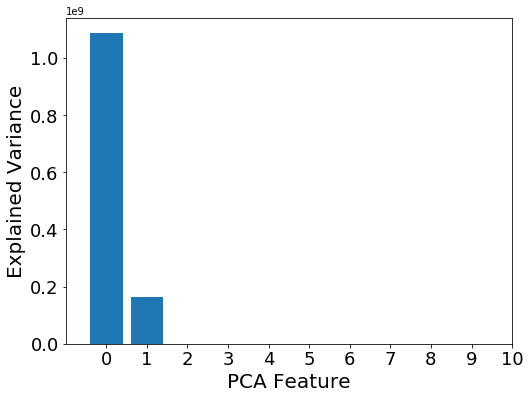

In [9]:
plt.figure(1, figsize=(8,6))
features = range(pca.n_components_)
ax = plt.bar(features, pca.explained_variance_)
plt.xticks(features)
plt.xlabel('PCA Feature', size=20)
plt.ylabel('Explained Variance', size=20)
plt.xlim(-1, 10)
_ = plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)
plt.savefig('Figures/PCA.png')

In [43]:
# Performing PCA on test/train data
X_train, X_test, y_train, y_test = train_test_split(X_dummy_sample, y_sample, test_size=0.25, random_state = 23)    # Setting testing and training data
pca = IncrementalPCA(n_components=2)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

## PCA Using Scaled Data

In [10]:
# Scaling X 
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X_dummy_sample)

In [11]:
# Fitting with IncrementalPCA
pca = IncrementalPCA()
time0 = time()
pca.fit(scaled_X)
time_taken = time() - time0
print('It took ' + str(time_taken) + 'sec to fit PCA')

It took 659.0517835617065sec to fit PCA


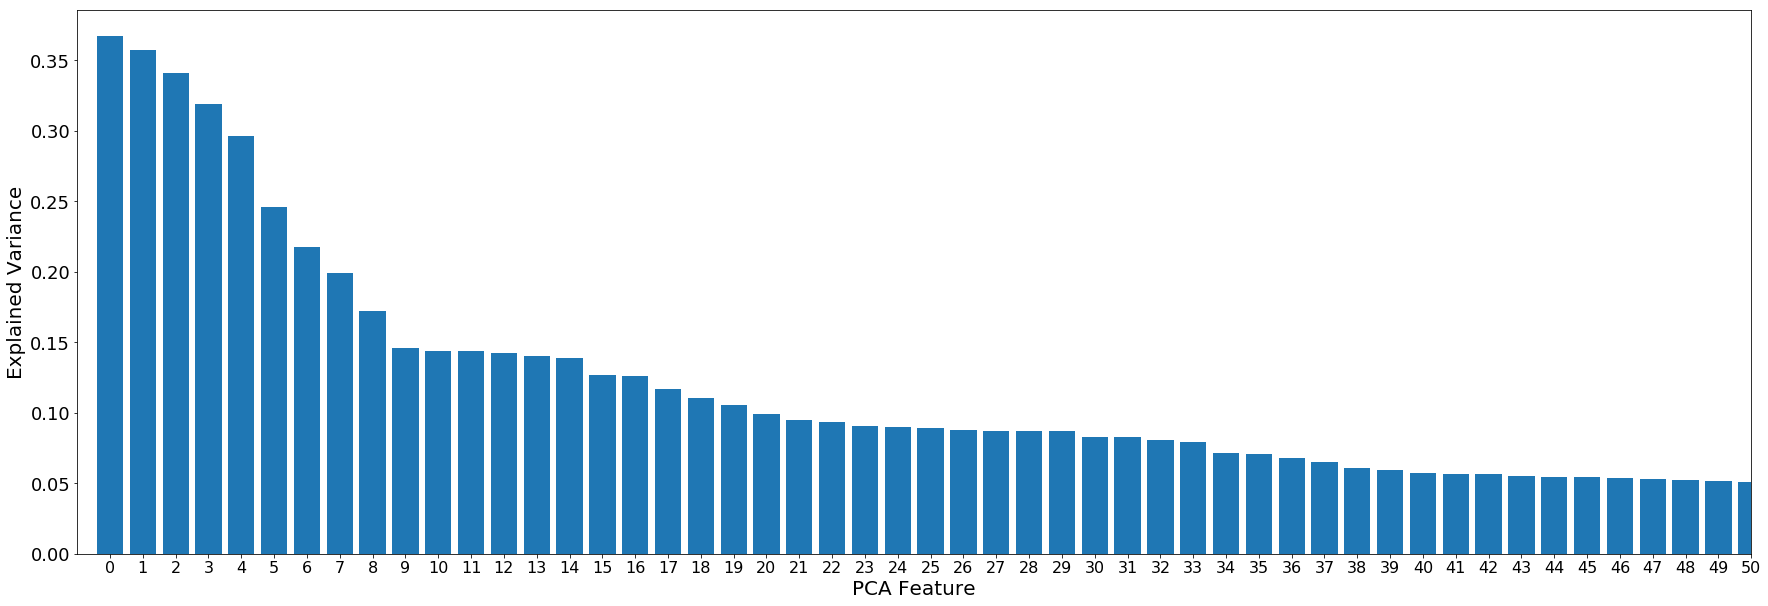

In [16]:
plt.figure(1, figsize=(30,10))
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xticks(features)
plt.xlabel('PCA Feature', size=20)
plt.ylabel('Explained Variance', size=20)
plt.xlim(-1, 50)
_ = plt.xticks(fontsize=16)
_ = plt.yticks(fontsize=18)
#plt.ylim(-1, 50)
plt.savefig('Figures/PCA_scaled.jpg', bbox_inches='tight')

In [13]:
# Creating train/test data and normalizing all features
X_train, X_test, y_train, y_test = train_test_split(X_dummy_sample, y_sample, test_size=0.25, random_state = 23)    # Setting testing and training data
scaler = MinMaxScaler()
scaled_Xtrain = scaler.fit_transform(X_train)
scaled_Xtest = scaler.transform(X_test)

In [14]:
# Performing PCA on scaled data
pca = IncrementalPCA(n_components=9)
X_train_pca = pca.fit_transform(scaled_Xtrain)
X_test_pca = pca.transform(scaled_Xtest)

### Setting X_train and X_test

In [12]:
#X_train = X_train_pca
#X_test = X_test_pca

X_train = scaled_Xtrain 
X_test = scaled_Xtest 

## SGD CLASSIFIER

### original

In [31]:
# Running SGD Classifier 

sgd = linear_model.SGDClassifier()  # Creating sgd classifier object

time0 = time()
model = sgd.fit(X_train, y_train)       # Training the model using the training sets
time_taken = time() - time0
print('It took ' + str(time_taken) + 'sec to train the model')

time0 = time()
y_pred = sgd.predict(X_test)            # Making predictions using the testing set
time_taken = time() - time0
print('It took ' + str(time_taken) + 'sec to test the model')

sgd

C:\Users\Anita\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


It took 264.0073285102844sec to train the model
It took 8.53083348274231sec to test the model


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [32]:
# Getting how many types of crime were predicted 
set(y_pred), len(set(y_pred))

({'ASSAULT',
  'BATTERY',
  'BURGLARY',
  'CRIMINAL DAMAGE',
  'CRIMINAL TRESPASS',
  'DECEPTIVE PRACTICE',
  'MOTOR VEHICLE THEFT',
  'NARCOTICS',
  'OTHER OFFENSE',
  'ROBBERY',
  'THEFT'},
 11)

In [33]:
# Getting train/test scores
print('Train R2 Score: %.3f' % model.score(X_train, y_train))
print('Test R2 Score: %.3f' % model.score(X_test, y_test))

Train R2 Score: 0.293
Test R2 Score: 0.293


In [34]:
# Converting predicted values to dummy variables
y_pred_dummy=pd.get_dummies(data = y_pred, prefix='', prefix_sep='')
y_test_dummy=pd.get_dummies(data = y_test, prefix='', prefix_sep='')

# Getting RMSE and F1 score
rmse_df, rmse_ave = rmse(y_pred_dummy, y_test_dummy)
f1_df, ave_f1_df = fscore(y_pred_dummy, y_test_dummy)
print('RMSE Table:\n' + str(rmse_df) + '\n\nAverage RMSE:  ' + str(rmse_ave) + '\n\nF1 Score Table:\n' + str(f1_df) + '\n\nAverage F1 Score:\n' + str(ave_f1_df))

RMSE Table:
           Primary Type      RMSE
0               ASSAULT  0.009309
1               BATTERY  0.011832
2              BURGLARY  0.016573
3       CRIMINAL DAMAGE  0.017814
4     CRIMINAL TRESPASS  0.016573
5    DECEPTIVE PRACTICE  0.017474
6   MOTOR VEHICLE THEFT  0.016411
7             NARCOTICS  0.014606
8         OTHER OFFENSE  0.008165
9               ROBBERY  0.014652
10                THEFT  0.006532

Average RMSE:  0.013631017724781975

F1 Score Table:
   Primary Type of Crime  True Positives  False Positives  True Negatives  \
0                ASSAULT            3264            29020          671407   
1                BATTERY           44913            85944          519382   
2               BURGLARY           12781            29065          675317   
3        CRIMINAL DAMAGE            9197            50495          608725   
4      CRIMINAL TRESPASS            1323             6137          721079   
5     DECEPTIVE PRACTICE            8056            29670       

### class_weight='balanced'

In [35]:
# Running SGD Classifier 

sgd = linear_model.SGDClassifier(class_weight='balanced')  # Creating sgd classifier object

time0 = time()
model = sgd.fit(X_train, y_train)       # Training the model using the training sets
time_taken = time() - time0
print('It took ' + str(time_taken) + 'sec to train the model')

time0 = time()
y_pred = sgd.predict(X_test)            # Making predictions using the testing set
time_taken = time() - time0
print('It took ' + str(time_taken) + 'sec to test the model')

sgd

C:\Users\Anita\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


It took 358.10485196113586sec to train the model
It took 9.319298028945923sec to test the model


SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [36]:
# Getting how many types of crime were predicted 
set(y_pred), len(set(y_pred))

({'ASSAULT',
  'BATTERY',
  'BURGLARY',
  'CRIMINAL DAMAGE',
  'CRIMINAL TRESPASS',
  'DECEPTIVE PRACTICE',
  'MOTOR VEHICLE THEFT',
  'NARCOTICS',
  'OTHER OFFENSE',
  'ROBBERY',
  'THEFT'},
 11)

In [37]:
# Getting train/test scores
print('Train R2 Score: %.3f' % model.score(X_train, y_train))
print('Test R2 Score: %.3f' % model.score(X_test, y_test))

Train R2 Score: 0.212
Test R2 Score: 0.212


In [38]:
# Converting predicted values to dummy variables
y_pred_dummy=pd.get_dummies(data = y_pred, prefix='', prefix_sep='')
# Converting test values to dummy variables
y_test_dummy=pd.get_dummies(data = y_test, prefix='', prefix_sep='')

# Getting RMSE and F1 score
rmse_df, rmse_ave = rmse(y_pred_dummy, y_test_dummy)
f1_df, ave_f1_df = fscore(y_pred_dummy, y_test_dummy)
print('RMSE Table:\n' + str(rmse_df) + '\n\nAverage RMSE:  ' + str(rmse_ave) + '\n\nF1 Score Table:\n' + str(f1_df) + '\n\nAverage F1 Score:\n' + str(ave_f1_df))

RMSE Table:
           Primary Type      RMSE
0               ASSAULT  0.009866
1               BATTERY  0.012220
2              BURGLARY  0.016733
3       CRIMINAL DAMAGE  0.012220
4     CRIMINAL TRESPASS  0.012000
5    DECEPTIVE PRACTICE  0.017851
6   MOTOR VEHICLE THEFT  0.017049
7             NARCOTICS  0.012543
8         OTHER OFFENSE  0.013711
9               ROBBERY  0.015748
10                THEFT  0.017474

Average RMSE:  0.014310539049413696

F1 Score Table:
   Primary Type of Crime  True Positives  False Positives  True Negatives  \
0                ASSAULT            7438            85426          615001   
1                BATTERY           22938            49384          555942   
2               BURGLARY           15360            39840          664542   
3        CRIMINAL DAMAGE           11711            68243          590977   
4      CRIMINAL TRESPASS            6098            28990          698226   
5     DECEPTIVE PRACTICE           13908            99020       

### class_weight='balanced', loss='log'

In [39]:
# Running SGD Classifier 

sgd = linear_model.SGDClassifier(class_weight = 'balanced', loss='log')  # Creating sgd classifier object

time0 = time()
model = sgd.fit(X_train, y_train)       # Training the model using the training sets
time_taken = time() - time0
print('It took ' + str(time_taken) + 'sec to train the model')

time0 = time()
y_pred = sgd.predict(X_test)            # Making predictions using the testing set
time_taken = time() - time0
print('It took ' + str(time_taken) + 'sec to test the model')

sgd

C:\Users\Anita\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


It took 382.01253151893616sec to train the model
It took 7.984402179718018sec to test the model


SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [40]:
# Getting how many types of crime were predicted 
set(y_pred), len(set(y_pred))

({'ASSAULT',
  'BATTERY',
  'BURGLARY',
  'CRIMINAL DAMAGE',
  'CRIMINAL TRESPASS',
  'DECEPTIVE PRACTICE',
  'MOTOR VEHICLE THEFT',
  'NARCOTICS',
  'OTHER OFFENSE',
  'ROBBERY',
  'THEFT'},
 11)

In [41]:
# Getting train/test scores
print('Train R2 Score: %.3f' % model.score(X_train, y_train))
print('Test R2 Score: %.3f' % model.score(X_test, y_test))

Train R2 Score: 0.301
Test R2 Score: 0.301


In [42]:
# Converting predicted values to dummy variables
y_pred_dummy=pd.get_dummies(data = y_pred, prefix='', prefix_sep='')

# Converting test values to dummy variables
y_test_dummy=pd.get_dummies(data = y_test, prefix='', prefix_sep='')

# Getting RMSE and F1 score
rmse_df, rmse_ave = rmse(y_pred_dummy, y_test_dummy)
f1_df, ave_f1_df = fscore(y_pred_dummy, y_test_dummy)
print('RMSE Table:\n' + str(rmse_df) + '\n\nAverage RMSE:  ' + str(rmse_ave) + '\n\nF1 Score Table:\n' + str(f1_df) + '\n\nAverage F1 Score:\n' + str(ave_f1_df))

RMSE Table:
           Primary Type      RMSE
0               ASSAULT  0.008406
1               BATTERY  0.009522
2              BURGLARY  0.004472
3       CRIMINAL DAMAGE  0.002309
4     CRIMINAL TRESPASS  0.012596
5    DECEPTIVE PRACTICE  0.017926
6   MOTOR VEHICLE THEFT  0.013760
7             NARCOTICS  0.002309
8         OTHER OFFENSE  0.005416
9               ROBBERY  0.009866
10                THEFT  0.010000

Average RMSE:  0.008780263128006227

F1 Score Table:
   Primary Type of Crime  True Positives  False Positives  True Negatives  \
0                ASSAULT            3384            14280          686147   
1                BATTERY           27221            36215          569111   
2               BURGLARY           23665            59982          644400   
3        CRIMINAL DAMAGE            3270             8494          650726   
4      CRIMINAL TRESPASS            8627            45866          681350   
5     DECEPTIVE PRACTICE           11330            31676       

## MULTINOMIAL NB

In [43]:
# Running Multinomial NB model

nb = MultinomialNB()  # Creating mulinomial object

time0 = time()
model = nb.fit(X_train, column_or_1d(y_train, warn=False))       # Training the model using the training sets
time_taken = time() - time0
print('It took ' + str(time_taken) + 'sec to train the model')

time0 = time()
y_pred = nb.predict(X_test)            # Making predictions using the testing set
time_taken = time() - time0
print('It took ' + str(time_taken) + 'sec to test the model')

nb

It took 79.25016641616821sec to train the model
It took 15.75097942352295sec to test the model


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [44]:
# Getting how many types of crime were predicted 
set(y_pred), len(set(y_pred))

({'ASSAULT',
  'BATTERY',
  'BURGLARY',
  'CRIMINAL DAMAGE',
  'CRIMINAL TRESPASS',
  'DECEPTIVE PRACTICE',
  'MOTOR VEHICLE THEFT',
  'NARCOTICS',
  'OTHER OFFENSE',
  'ROBBERY',
  'THEFT'},
 11)

In [45]:
# Getting train/test scores
print('Train R2 Score: %.3f' % model.score(X_train, y_train))
print('Test R2 Score: %.3f' % model.score(X_test, y_test))

Train R2 Score: 0.318
Test R2 Score: 0.318


In [46]:
# Converting predicted values to dummy variables
y_pred_dummy=pd.get_dummies(data = y_pred, prefix='', prefix_sep='')
# Converting test values to dummy variables
y_test_dummy=pd.get_dummies(data = y_test, prefix='', prefix_sep='')

# Getting RMSE and F1 score
rmse_df, rmse_ave = rmse(y_pred_dummy, y_test_dummy)
f1_df, ave_f1_df = fscore(y_pred_dummy, y_test_dummy)
print('RMSE Table:\n' + str(rmse_df) + '\n\nAverage RMSE:  ' + str(rmse_ave) + '\n\nF1 Score Table:\n' + str(f1_df) + '\n\nAverage F1 Score:\n' + str(ave_f1_df))

RMSE Table:
           Primary Type      RMSE
0               ASSAULT  0.006831
1               BATTERY  0.006325
2              BURGLARY  0.015916
3       CRIMINAL DAMAGE  0.008641
4     CRIMINAL TRESPASS  0.007832
5    DECEPTIVE PRACTICE  0.008641
6   MOTOR VEHICLE THEFT  0.011719
7             NARCOTICS  0.018184
8         OTHER OFFENSE  0.009238
9               ROBBERY  0.005416
10                THEFT  0.017127

Average RMSE:  0.010533601738480572

F1 Score Table:
   Primary Type of Crime  True Positives  False Positives  True Negatives  \
0                ASSAULT            1912            10742          689685   
1                BATTERY           57425           128589          476737   
2               BURGLARY           14684            34536          669846   
3        CRIMINAL DAMAGE           16309            58961          600259   
4      CRIMINAL TRESPASS            4560            18942          708274   
5     DECEPTIVE PRACTICE            6548            11605       

## DECISION TREE CLASSIFIER

### Original

In [47]:
# Running Decision Tree Classifier

dtc = DecisionTreeClassifier()  # Creating decision tree classifier object

time0 = time()
model = dtc.fit(X_train, y_train)       # Training the model using the training sets
time_taken = time() - time0
print('It took ' + str(time_taken) + 'sec to train the model')

time0 = time()
y_pred = dtc.predict(X_test)            # Making predictions using the testing set
time_taken = time() - time0
print('It took ' + str(time_taken) + 'sec to test the model')

dtc

It took 498.4118695259094sec to train the model
It took 8.799418210983276sec to test the model


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [48]:
# Getting train/test scores
print('Train R2 Score: %.3f' % model.score(X_train, y_train))
print('Test R2 Score: %.3f' % model.score(X_test, y_test))

Train R2 Score: 0.995
Test R2 Score: 0.274


In [49]:
# Getting how many types of crime were predicted 
set(y_pred), len(set(y_pred))

({'ASSAULT',
  'BATTERY',
  'BURGLARY',
  'CRIMINAL DAMAGE',
  'CRIMINAL TRESPASS',
  'DECEPTIVE PRACTICE',
  'MOTOR VEHICLE THEFT',
  'NARCOTICS',
  'OTHER OFFENSE',
  'ROBBERY',
  'THEFT'},
 11)

In [50]:
# Converting predicted values to dummy variables
y_pred_dummy=pd.get_dummies(data = y_pred, prefix='', prefix_sep='')

# Converting test values to dummy variables
y_test_dummy=pd.get_dummies(data = y_test, prefix='', prefix_sep='')

# Getting RMSE and F1 score
rmse_df, rmse_ave = rmse(y_pred_dummy, y_test_dummy)
f1_df, ave_f1_df = fscore(y_pred_dummy, y_test_dummy)
print('RMSE Table:\n' + str(rmse_df) + '\n\nAverage RMSE:  ' + str(rmse_ave) + '\n\nF1 Score Table:\n' + str(f1_df) + '\n\nAverage F1 Score:\n' + str(ave_f1_df))

RMSE Table:
           Primary Type      RMSE
0               ASSAULT  0.012437
1               BATTERY  0.009798
2              BURGLARY  0.008794
3       CRIMINAL DAMAGE  0.018074
4     CRIMINAL TRESPASS  0.013115
5    DECEPTIVE PRACTICE  0.018294
6   MOTOR VEHICLE THEFT  0.014142
7             NARCOTICS  0.017776
8         OTHER OFFENSE  0.005416
9               ROBBERY  0.010392
10                THEFT  0.015620

Average RMSE:  0.01307804111354855

F1 Score Table:
   Primary Type of Crime  True Positives  False Positives  True Negatives  \
0                ASSAULT            5279            44910          655517   
1                BATTERY           43180           101330          503996   
2               BURGLARY           12758            33246          671136   
3        CRIMINAL DAMAGE           17788            74197          585023   
4      CRIMINAL TRESPASS            4167            18888          708328   
5     DECEPTIVE PRACTICE            6942            23970        

### class_weight='balanced

In [51]:
# Running Decision Tree Classifier

dtc = DecisionTreeClassifier(class_weight='balanced')  # Creating decision tree classifier object

time0 = time()
model = dtc.fit(X_train, y_train)       # Training the model using the training sets
time_taken = time() - time0
print('It took ' + str(time_taken) + 'sec to train the model')

time0 = time()
y_pred = dtc.predict(X_test)            # Making predictions using the testing set
time_taken = time() - time0
print('It took ' + str(time_taken) + 'sec to test the model')

dtc

It took 582.1030375957489sec to train the model
It took 8.844649076461792sec to test the model


DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [52]:
# Getting train/test scores
print('Train R2 Score: %.3f' % model.score(X_train, y_train))
print('Test R2 Score: %.3f' % model.score(X_test, y_test))

Train R2 Score: 0.994
Test R2 Score: 0.269


In [53]:
# Getting how many types of crime were predicted 
set(y_pred), len(set(y_pred))

({'ASSAULT',
  'BATTERY',
  'BURGLARY',
  'CRIMINAL DAMAGE',
  'CRIMINAL TRESPASS',
  'DECEPTIVE PRACTICE',
  'MOTOR VEHICLE THEFT',
  'NARCOTICS',
  'OTHER OFFENSE',
  'ROBBERY',
  'THEFT'},
 11)

In [54]:
# Converting predicted values to dummy variables
y_pred_dummy=pd.get_dummies(data = y_pred, prefix='', prefix_sep='')

# Converting test values to dummy variables
y_test_dummy=pd.get_dummies(data = y_test, prefix='', prefix_sep='')

# Getting RMSE and F1 score
rmse_df, rmse_ave = rmse(y_pred_dummy, y_test_dummy)
f1_df, ave_f1_df = fscore(y_pred_dummy, y_test_dummy)
print('RMSE Table:\n' + str(rmse_df) + '\n\nAverage RMSE:  ' + str(rmse_ave) + '\n\nF1 Score Table:\n' + str(f1_df) + '\n\nAverage F1 Score:\n' + str(ave_f1_df))

RMSE Table:
           Primary Type      RMSE
0               ASSAULT  0.016813
1               BATTERY  0.008406
2              BURGLARY  0.018074
3       CRIMINAL DAMAGE  0.018111
4     CRIMINAL TRESPASS  0.014329
5    DECEPTIVE PRACTICE  0.008869
6   MOTOR VEHICLE THEFT  0.016289
7             NARCOTICS  0.015663
8         OTHER OFFENSE  0.016852
9               ROBBERY  0.014967
10                THEFT  0.017166

Average RMSE:  0.015049052311908924

F1 Score Table:
   Primary Type of Crime  True Positives  False Positives  True Negatives  \
0                ASSAULT            5583            47358          653069   
1                BATTERY           42175           100050          505276   
2               BURGLARY           12573            33504          670878   
3        CRIMINAL DAMAGE           16935            71297          587923   
4      CRIMINAL TRESPASS            4531            22093          705123   
5     DECEPTIVE PRACTICE            7268            26408       

## EXTRA TREE CLASSIFIER

### Original

In [55]:
# Running Extra Tree Classifier

etc = ExtraTreeClassifier()  # Creating extra tree classifier object

time0 = time()
model = etc.fit(X_train, y_train)       # Training the model using the training sets
time_taken = time() - time0
print('It took ' + str(time_taken) + 'sec to train the model')

time0 = time()
y_pred = etc.predict(X_test)            # Making predictions using the testing set
time_taken = time() - time0
print('It took ' + str(time_taken) + 'sec to test the model')

etc

It took 125.02069759368896sec to train the model
It took 9.109970569610596sec to test the model


ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, random_state=None,
          splitter='random')

In [56]:
# Getting how many types of crime were predicted 
set(y_pred), len(set(y_pred))

({'ASSAULT',
  'BATTERY',
  'BURGLARY',
  'CRIMINAL DAMAGE',
  'CRIMINAL TRESPASS',
  'DECEPTIVE PRACTICE',
  'MOTOR VEHICLE THEFT',
  'NARCOTICS',
  'OTHER OFFENSE',
  'ROBBERY',
  'THEFT'},
 11)

In [57]:
# Getting train/test scores
print('Train R2 Score: %.3f' % model.score(X_train, y_train))
print('Test R2 Score: %.3f' % model.score(X_test, y_test))

Train R2 Score: 0.995
Test R2 Score: 0.260


In [58]:
# Converting predicted values to dummy variables
y_pred_dummy=pd.get_dummies(data = y_pred, prefix='', prefix_sep='')

# Converting test values to dummy variables
y_test_dummy=pd.get_dummies(data = y_test, prefix='', prefix_sep='')

# Getting RMSE and F1 score
rmse_df, rmse_ave = rmse(y_pred_dummy, y_test_dummy)
f1_df, ave_f1_df = fscore(y_pred_dummy, y_test_dummy)
print('RMSE Table:\n' + str(rmse_df) + '\n\nAverage RMSE:  ' + str(rmse_ave) + '\n\nF1 Score Table:\n' + str(f1_df) + '\n\nAverage F1 Score:\n' + str(ave_f1_df))

RMSE Table:
           Primary Type      RMSE
0               ASSAULT  0.013515
1               BATTERY  0.009238
2              BURGLARY  0.011662
3       CRIMINAL DAMAGE  0.007916
4     CRIMINAL TRESPASS  0.006532
5    DECEPTIVE PRACTICE  0.003830
6   MOTOR VEHICLE THEFT  0.009309
7             NARCOTICS  0.006325
8         OTHER OFFENSE  0.017626
9               ROBBERY  0.012858
10                THEFT  0.015535

Average RMSE:  0.010395066900426396

F1 Score Table:
   Primary Type of Crime  True Positives  False Positives  True Negatives  \
0                ASSAULT            4825            44989          655438   
1                BATTERY           41935           102637          502689   
2               BURGLARY           11901            33713          670669   
3        CRIMINAL DAMAGE           16673            74164          585056   
4      CRIMINAL TRESPASS            3659            19563          707653   
5     DECEPTIVE PRACTICE            6266            24078       

### class_weight='balanced'

In [59]:
# Running Extra Tree Classifier

etc = ExtraTreeClassifier(class_weight='balanced')  # Creating extra tree classifier object

time0 = time()
model = etc.fit(X_train, y_train)       # Training the model using the training sets
time_taken = time() - time0
print('It took ' + str(time_taken) + 'sec to train the model')

time0 = time()
y_pred = etc.predict(X_test)            # Making predictions using the testing set
time_taken = time() - time0
print('It took ' + str(time_taken) + 'sec to test the model')

etc

It took 155.83495450019836sec to train the model
It took 9.09888744354248sec to test the model


ExtraTreeClassifier(class_weight='balanced', criterion='gini', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, random_state=None,
          splitter='random')

In [60]:
# Getting how many types of crime were predicted 
set(y_pred), len(set(y_pred))

({'ASSAULT',
  'BATTERY',
  'BURGLARY',
  'CRIMINAL DAMAGE',
  'CRIMINAL TRESPASS',
  'DECEPTIVE PRACTICE',
  'MOTOR VEHICLE THEFT',
  'NARCOTICS',
  'OTHER OFFENSE',
  'ROBBERY',
  'THEFT'},
 11)

In [61]:
# Getting train/test scores
print('Train R2 Score: %.3f' % model.score(X_train, y_train))
print('Test R2 Score: %.3f' % model.score(X_test, y_test))

Train R2 Score: 0.994
Test R2 Score: 0.258


In [62]:
# Converting predicted values to dummy variables
y_pred_dummy=pd.get_dummies(data = y_pred, prefix='', prefix_sep='')

# Converting test values to dummy variables
y_test_dummy=pd.get_dummies(data = y_test, prefix='', prefix_sep='')

# Getting RMSE and F1 score
rmse_df, rmse_ave = rmse(y_pred_dummy, y_test_dummy)
f1_df, ave_f1_df = fscore(y_pred_dummy, y_test_dummy)
print('RMSE Table:\n' + str(rmse_df) + '\n\nAverage RMSE:  ' + str(rmse_ave) + '\n\nF1 Score Table:\n' + str(f1_df) + '\n\nAverage F1 Score:\n' + str(ave_f1_df))

RMSE Table:
           Primary Type      RMSE
0               ASSAULT  0.014422
1               BATTERY  0.010132
2              BURGLARY  0.013317
3       CRIMINAL DAMAGE  0.013466
4     CRIMINAL TRESPASS  0.007832
5    DECEPTIVE PRACTICE  0.016852
6   MOTOR VEHICLE THEFT  0.008641
7             NARCOTICS  0.005033
8         OTHER OFFENSE  0.017889
9               ROBBERY  0.014877
10                THEFT  0.017049

Average RMSE:  0.012682742082067329

F1 Score Table:
   Primary Type of Crime  True Positives  False Positives  True Negatives  \
0                ASSAULT            4798            44725          655702   
1                BATTERY           41405           102888          502438   
2               BURGLARY           11734            33577          670805   
3        CRIMINAL DAMAGE           16453            73521          585699   
4      CRIMINAL TRESPASS            3743            19917          707299   
5     DECEPTIVE PRACTICE            6384            24654       

## GAUSSIAN NB

In [63]:
# Running Gaussian NB

gnb = GaussianNB()  # Creating Gaussian NB object

time0 = time()
model = gnb.fit(X_train, y_train)       # Training the model using the training sets
time_taken = time() - time0
print('It took ' + str(time_taken) + 'sec to train the model')

time0 = time()
y_pred = gnb.predict(X_test)            # Making predictions using the testing set
time_taken = time() - time0
print('It took ' + str(time_taken) + 'sec to test the model')

gnb

It took 244.7376651763916sec to train the model
It took 140.7107448577881sec to test the model


GaussianNB(priors=None)

In [64]:
# Getting how many types of crime were predicted 
set(y_pred), len(set(y_pred))

({'ASSAULT',
  'BATTERY',
  'BURGLARY',
  'CRIMINAL DAMAGE',
  'CRIMINAL TRESPASS',
  'DECEPTIVE PRACTICE',
  'MOTOR VEHICLE THEFT',
  'NARCOTICS',
  'OTHER OFFENSE',
  'ROBBERY',
  'THEFT'},
 11)

In [63]:
# Getting train/test scores - took too long to get the train score for some reason
print('Train R2 Score: %.3f' % model.score(X_train, y_train))
print('Test R2 Score: %.3f' % model.score(X_test, y_test))

Train R2 Score: 0.262
Test R2 Score: 0.262


In [65]:
# Calculating the percentage of correct predictions
correct = np.sum(y_pred == y_test) * 100 / len(y_pred)
print('Percent of correct predictions:  ', correct)

# Converting predicted values to dummy variables
y_pred_dummy=pd.get_dummies(data = y_pred, prefix='', prefix_sep='')
# Converting test values to dummy variables
y_test_dummy=pd.get_dummies(data = y_test, prefix='', prefix_sep='')

# Getting RMSE and F1 score
rmse_df, rmse_ave = rmse(y_pred_dummy, y_test_dummy)
f1_df, ave_f1_df = fscore(y_pred_dummy, y_test_dummy)
print('RMSE Table:\n' + str(rmse_df) + '\n\nAverage RMSE:  ' + str(rmse_ave) + '\n\nF1 Score Table:\n' + str(f1_df) + '\n\nAverage F1 Score:\n' + str(ave_f1_df))

Percent of correct predictions:   16.550933333333333
RMSE Table:
           Primary Type      RMSE
0               ASSAULT  0.011547
1               BATTERY  0.014967
2              BURGLARY  0.009452
3       CRIMINAL DAMAGE  0.011136
4     CRIMINAL TRESPASS  0.014283
5    DECEPTIVE PRACTICE  0.017550
6   MOTOR VEHICLE THEFT  0.007572
7             NARCOTICS  0.018257
8         OTHER OFFENSE  0.013013
9               ROBBERY  0.012275
10                THEFT  0.010770

Average RMSE:  0.012801877802128043

F1 Score Table:
   Primary Type of Crime  True Positives  False Positives  True Negatives  \
0                ASSAULT             494             2733          697694   
1                BATTERY            2246             3148          602178   
2               BURGLARY           21274           105003          599379   
3        CRIMINAL DAMAGE             353             1314          657906   
4      CRIMINAL TRESPASS            3021            18022          709194   
5     DECEP

## Random Forest

### Original

In [66]:
# Running Random Forest

rf = RandomForestClassifier()  # Creating random forest classifier object

time0 = time()
model = rf.fit(X_train, y_train)       # Training the model using the training sets
time_taken = time() - time0
print('It took ' + str(time_taken) + 'sec to train the model')

time0 = time()
y_pred = rf.predict(X_test)            # Making predictions using the testing set
time_taken = time() - time0
print('It took ' + str(time_taken) + 'sec to test the model')

rf

It took 471.28761410713196sec to train the model
It took 19.613672971725464sec to test the model


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [67]:
# Getting how many types of crime were predicted 
set(y_pred), len(set(y_pred))

({'ASSAULT',
  'BATTERY',
  'BURGLARY',
  'CRIMINAL DAMAGE',
  'CRIMINAL TRESPASS',
  'DECEPTIVE PRACTICE',
  'MOTOR VEHICLE THEFT',
  'NARCOTICS',
  'OTHER OFFENSE',
  'ROBBERY',
  'THEFT'},
 11)

In [68]:
# Getting train/test scores 
print('Train R2 Score: %.3f' % model.score(X_train, y_train))
print('Test R2 Score: %.3f' % model.score(X_test, y_test))

Train R2 Score: 0.981
Test R2 Score: 0.328


In [69]:
# Converting predicted values to dummy variables
y_pred_dummy=pd.get_dummies(data = y_pred, prefix='', prefix_sep='')

# Converting test values to dummy variables
y_test_dummy=pd.get_dummies(data = y_test, prefix='', prefix_sep='')

# Getting RMSE and F1 score
rmse_df, rmse_ave = rmse(y_pred_dummy, y_test_dummy)
f1_df, ave_f1_df = fscore(y_pred_dummy, y_test_dummy)
print('RMSE Table:\n' + str(rmse_df) + '\n\nAverage RMSE:  ' + str(rmse_ave) + '\n\nF1 Score Table:\n' + str(f1_df) + '\n\nAverage F1 Score:\n' + str(ave_f1_df))

RMSE Table:
           Primary Type      RMSE
0               ASSAULT  0.015916
1               BATTERY  0.009661
2              BURGLARY  0.016533
3       CRIMINAL DAMAGE  0.013614
4     CRIMINAL TRESPASS  0.010000
5    DECEPTIVE PRACTICE  0.016452
6   MOTOR VEHICLE THEFT  0.013711
7             NARCOTICS  0.008641
8         OTHER OFFENSE  0.015875
9               ROBBERY  0.016773
10                THEFT  0.008246

Average RMSE:  0.013220167357244256

F1 Score Table:
   Primary Type of Crime  True Positives  False Positives  True Negatives  \
0                ASSAULT            4620            35365          665062   
1                BATTERY           64451           142311          463015   
2               BURGLARY           15139            30142          674240   
3        CRIMINAL DAMAGE           17272            64871          594349   
4      CRIMINAL TRESPASS            4115             9310          717906   
5     DECEPTIVE PRACTICE            6628            12856       

### class_weight='balanced'

In [70]:
# Running Random Forest
#X_train, X_test, y_train, y_test = train_test_split(X_dummy_sample, y_sample, test_size=0.25, random_state = 23)    # Setting testing and training data

rf = RandomForestClassifier(class_weight='balanced')  # Creating random forest classifier object

time0 = time()
model = rf.fit(X_train, y_train)       # Training the model using the training sets
time_taken = time() - time0
print('It took ' + str(time_taken) + 'sec to train the model')

time0 = time()
y_pred = rf.predict(X_test)            # Making predictions using the testing set
time_taken = time() - time0
print('It took ' + str(time_taken) + 'sec to test the model')

rf

It took 531.997796535492sec to train the model
It took 19.544611930847168sec to test the model


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [71]:
# Getting how many types of crime were predicted 
set(y_pred), len(set(y_pred))

({'ASSAULT',
  'BATTERY',
  'BURGLARY',
  'CRIMINAL DAMAGE',
  'CRIMINAL TRESPASS',
  'DECEPTIVE PRACTICE',
  'MOTOR VEHICLE THEFT',
  'NARCOTICS',
  'OTHER OFFENSE',
  'ROBBERY',
  'THEFT'},
 11)

In [72]:
# Getting train/test scores 
print('Train R2 Score: %.3f' % model.score(X_train, y_train))
print('Test R2 Score: %.3f' % model.score(X_test, y_test))

Train R2 Score: 0.981
Test R2 Score: 0.326


In [73]:
# Converting predicted values to dummy variables
y_pred_dummy=pd.get_dummies(data = y_pred, prefix='', prefix_sep='')

# Converting test values to dummy variables
y_test_dummy=pd.get_dummies(data = y_test, prefix='', prefix_sep='')

# Getting RMSE and F1 score
rmse_df, rmse_ave = rmse(y_pred_dummy, y_test_dummy)
f1_df, ave_f1_df = fscore(y_pred_dummy, y_test_dummy)
print('RMSE Table:\n' + str(rmse_df) + '\n\nAverage RMSE:  ' + str(rmse_ave) + '\n\nF1 Score Table:\n' + str(f1_df) + '\n\nAverage F1 Score:\n' + str(ave_f1_df))

RMSE Table:
           Primary Type      RMSE
0               ASSAULT  0.018330
1               BATTERY  0.001633
2              BURGLARY  0.013064
3       CRIMINAL DAMAGE  0.012055
4     CRIMINAL TRESPASS  0.010832
5    DECEPTIVE PRACTICE  0.006218
6   MOTOR VEHICLE THEFT  0.005888
7             NARCOTICS  0.015144
8         OTHER OFFENSE  0.009866
9               ROBBERY  0.017889
10                THEFT  0.011719

Average RMSE:  0.011148891723326766

F1 Score Table:
   Primary Type of Crime  True Positives  False Positives  True Negatives  \
0                ASSAULT            4584            35647          664780   
1                BATTERY           63631           140143          465183   
2               BURGLARY           15081            30775          673607   
3        CRIMINAL DAMAGE           17153            64466          594754   
4      CRIMINAL TRESPASS            4314            10034          717182   
5     DECEPTIVE PRACTICE            6964            13274       

## Important Features

### SGD Classifier

In [13]:
# Running SGD Classifier 

sgd = linear_model.SGDClassifier(class_weight = 'balanced', loss='log')  # Creating sgd classifier object

time0 = time()
model = sgd.fit(X_train, y_train)       # Training the model using the training sets
time_taken = time() - time0
print('It took ' + str(time_taken) + 'sec to train the model')

sgd

C:\Users\Anita\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


It took 389.27533054351807sec to train the model


SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [14]:
# Getting feature coefficients
imp = sgd.coef_
imp[:10]

array([[ 0.32510839, -0.02835276,  0.14997786, ..., -0.01384315,
         0.09603744,  0.01819736],
       [ 0.18790873, -0.07051633,  0.07604258, ...,  0.01973259,
         0.06882616, -0.02797344],
       [ 0.53822796,  0.40364542,  0.1176922 , ..., -0.04747932,
        -0.16007709,  0.06063351],
       ...,
       [-0.21862009, -0.02860679, -0.02724941, ...,  0.03059964,
         0.32758026, -0.07787725],
       [ 0.21186299,  0.47643568,  0.2288778 , ...,  0.00550061,
         0.03001669, -0.03435084],
       [ 0.6813049 ,  0.08755858, -0.54282437, ...,  0.03349194,
        -0.15810681, -0.01790673]])

In [15]:
np.shape(imp)

(11, 652)

In [16]:
#  Converting to dataframe
imp_df = pd.DataFrame(imp)

In [17]:
imp_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651
0,0.325108,-0.028353,0.149978,-0.045377,0.423755,-0.319833,-0.003005,-0.615388,0.036447,0.019955,-0.010038,0.051770,0.006103,0.012113,0.012565,-0.011212,-0.007741,-0.009240,-0.143509,0.003401,-0.043657,-0.148287,0.108917,0.011322,0.299527,-0.007780,-0.186895,-0.465476,0.001045,-0.614080,-0.007501,0.118165,-0.052611,0.029963,-0.021779,0.063773,0.003860,0.356986,0.159894,0.029841,-0.071417,0.110569,0.050438,0.042416,-0.010742,-0.007849,-0.572603,0.301980,-0.016030,0.484749,-0.062270,-0.163171,-0.219795,0.223270,-0.010032,-0.458644,-0.205959,0.215993,-0.103048,-0.888272,-0.307300,-0.320298,0.167233,-0.000660,0.191239,-0.080159,0.001511,0.161169,0.880655,-0.222317,0.057829,0.0,0.634553,0.172791,0.084549,-0.014050,0.589156,0.317516,-0.014365,-0.007194,0.301507,0.034447,-0.017753,-0.320155,0.038417,-0.355231,0.028478,-0.028406,-0.028043,0.078818,1.000148,-1.691445,0.215228,0.462255,-0.000277,0.522118,0.317344,1.212258,0.758041,0.452748,-0.150470,-0.095868,-0.106546,0.291118,-0.110197,-0.715580,-1.036973,-0.242484,-0.000393,-0.000135,-0.002128,0.012152,0.005520,-0.178366,-0.055169,-0.106743,0.236894,-0.038464,-0.109468,-0.018875,0.031333,0.146193,-0.019687,0.038982,-0.046327,-0.076534,0.002266,-0.012423,0.108381,0.011781,-0.037005,-0.056858,0.020920,0.027445,0.008008,0.110943,0.054961,0.119361,-0.000879,0.029318,-0.034690,0.036699,-0.052008,-0.026941,-0.018254,0.014443,0.070531,0.053158,0.072959,-0.063009,0.013822,-0.022338,-0.012326,0.112510,-0.099880,-0.008259,-0.055536,0.025173,0.

In [18]:
# Adding column and index names
imp_df.columns = X_dummy_sample.columns
imp_df.index = sgd.classes_
imp_df

,X Coordinate,Y Coordinate,Distance from Closest Train Stop (km),Square Root of Distance from Closest Liquor Store (km),Distance from Chicago (km),Square Root of Distance from Closest Police Station (km),Square Root of Distance from Closest Bus Stop (km),Location Description_ABANDONED BUILDING,Location Description_AIRCRAFT,Location Description_AIRPORT BUILDING NON-TERMINAL-NON-SECURE AREA,Location Description_AIRPORT BUILDING NON-TERMINAL-SECURE AREA,Location Description_AIRPORT EXTERIOR-NON-SECURE AREA,Location Description_AIRPORT EXTERIOR-SECURE AREA,Location Description_AIRPORT PARKING LOT,Location Description_AIRPORT TERMINAL LOWER LEVEL-NON-SECURE AREA,Location Description_AIRPORT TERMINAL LOWER LEVEL-SECURE AREA,Location Description_AIRPORT TERMINAL MEZZANINE-NON-SECURE AREA,Location Description_AIRPORT TERMINAL UPPER LEVEL-NON-SECURE AREA,Location Description_AIRPORT TERMINAL UPPER LEVEL-SECURE AREA,Location Description_AIRPORT TRANSPORTATION SYSTEM (ATS),Location Description_AIRPORT VENDING ESTABLISHMENT,Location Description_AIRPORT/AIRCRAFT,Location Description_ALLEY,Location Description_ANIMAL HOSPITAL,Location Description_APARTMENT,Location Description_APPLIANCE STORE,Location Description_ATHLETIC CLUB,Location Description_ATM (AUTOMATIC TELLER MACHINE),Location Description_AUTO/BOAT/RV DEALERSHIP,Location Description_BANK,Location Description_BAR OR TAVERN,Location Description_BARBERSHOP,Location Description_BOAT/WATERCRAFT,Location Description_BOWLING ALLEY,Location Description_BRIDGE,Location Description_CAR WASH,Location Description_CEMETARY,Location Description_CHA APARTMENT,Location Description_CHA HALLWAY/STAIRWELL/ELEVATOR,Location Description_CHA PARKING LOT/GROUNDS,Location Description_CHURCH/SYNAGOGUE/PLACE OF WORSHIP,Location Description_CLEANING STORE,Location Description_COIN OPERATED MACHINE,Location Description_COLLEGE/UNIVERSITY GROUNDS,Location Description_COLLEGE/UNIVERSITY RESIDENCE HALL,Location Description_COMMERCIAL/BUSINESS OFFICE,Location Description_CONSTRUCTION SITE,Location Description_CONVENIENCE STORE,Location Description_CREDIT UNION,Location Description_CTA BUS,Location Description_CTA BUS STOP,Location Description_CTA GARAGE/OTHER PROPERTY,Location Description_CTA PLATFORM,Location Description_CTA STATION,Location Description_CTA TRACKS-RIGHT OF WAY,Location Description_CTA TRAIN,Location Description_CURRENCY EXCHANGE,Location Description_DAY CARE CENTER,Location Description_DELIVERY TRUCK,Location Description_DEPARTMENT STORE,Location Description_DRIVEWAY-RESIDENTIAL,Location Description_DRUG STORE,Location Description_FACTORY/MANUFACTURING BUILDING,Location Description_FARM,Location Description_FEDERAL BUILDING,Location Description_FIRE STATION,Location Description_FOREST PRESERVE,Location Description_GAS STATION,Location Description_GOVERNMENT BUILDING/PROPERTY,Location Description_GROCERY FOOD STORE,Location Description_HIGHWAY/EXPRESSWAY,Location Description_HORSE STABLE,Location Description_HOSPITAL BUILDING/GROUNDS,Location Description_HOTEL/MOTEL,Location Description_JAIL/LOCK-UP FACILITY,Location Description_LAKEFRONT/WATERFRONT/RIVERBANK,Location Description_LIBRARY,Location Description_MEDICAL/DENTAL OFFICE,Location Description_MOVIE HOUSE/THEATER,Location Description_NEWSSTAND,Location Description_NURSING HOME/RETIREMENT HOME,Location Description_OTHER,Location Description_OTHER COMMERCIAL TRANSPORTATION,Location Description_OTHER RAILROAD PROP/TRAIN DEPOT,Location Description_PARK PROPERTY,Location Description_PARKING LOT/GARAGE(NON.RESID.),Location Description_PAWN SHOP,Location Description_POLICE FACILITY/VEH PARKING LOT,Location Description_POOL ROOM,Location Description_RESIDENCE,Location Description_RESIDENCE PORCH/HALLWAY,Location Description_RESIDENCE-GARAGE,Location Description_RESIDENTIAL YARD (FRONT/BACK),Location Description_RESTAURANT,Location Description_SAVINGS AND LOAN,"Location Description_SCHOOL, PRIVATE, BUILDING","Location Description_SCHOOL, PRIVATE, 

Text(0.5,0,'Coefficient')

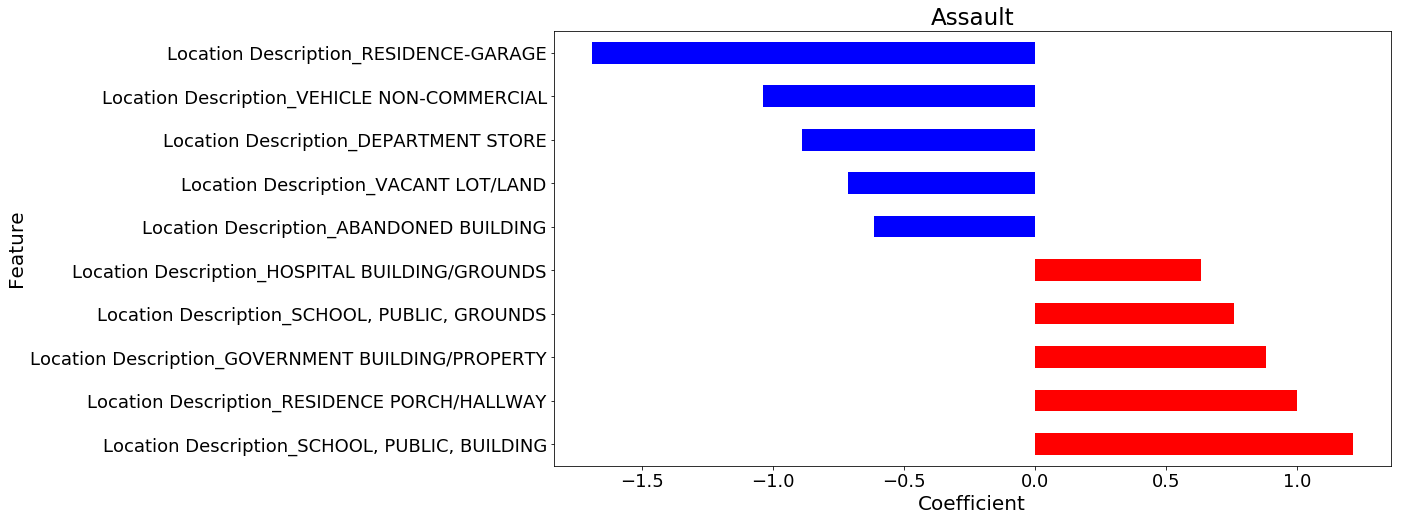

In [19]:
# Getting top 10 coefficients for assault
imp_assault = pd.DataFrame(imp_df.loc['ASSAULT', :])
imp_assault['Magnitude'] = abs(imp_assault['ASSAULT'])
imp_assault.columns = ['Coefficient', 'Magnitude']
imp_assault['Positive'] = imp_assault['Coefficient'] > 0

imp_assault = imp_assault.sort_values(by='Magnitude', ascending=False)[:10]
imp_assault = imp_assault.sort_values(by='Coefficient', ascending=False)

# Barplot
imp_assault.plot.barh(y='Coefficient', figsize = (15,8), legend=False, color=imp_assault['Positive'].map({True: 'r', False: 'b'}))
plt.title('Assault', size=23)
_ = plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)
plt.ylabel('Feature', size=20)
plt.xlabel('Coefficient', size=20)
#plt.savefig('../Figures/assault.jpg', bbox_inches='tight')

Text(0.5,0,'Coefficient')

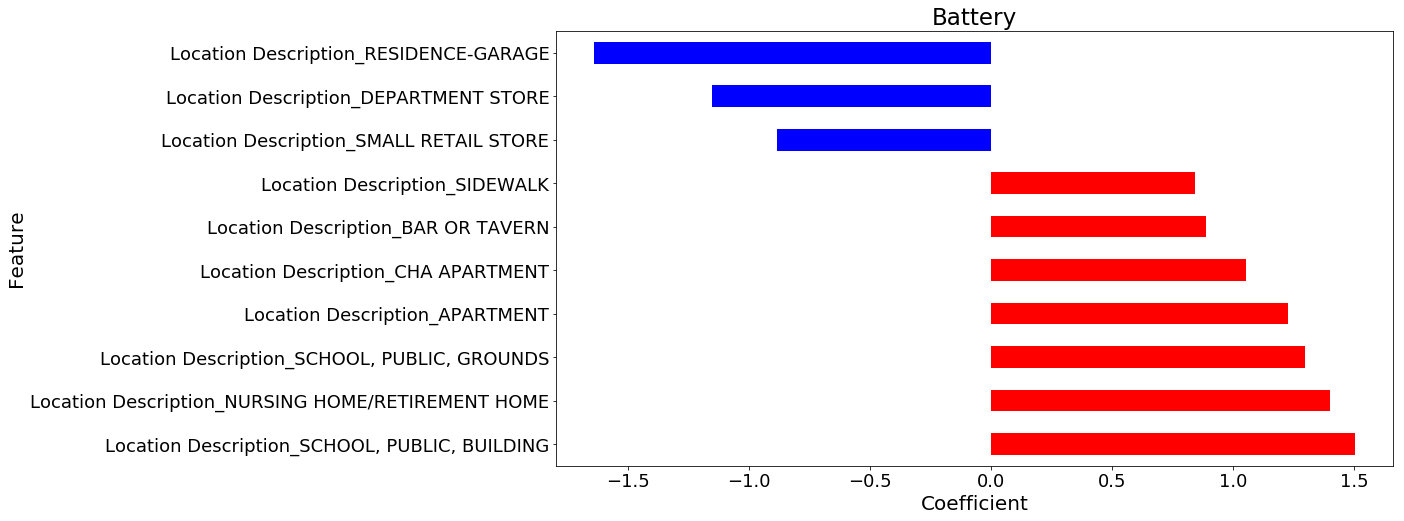

In [20]:
# Getting top 10 coefficients for battery
imp_bat = pd.DataFrame(imp_df.loc['BATTERY', :])
imp_bat['Magnitude'] = abs(imp_bat['BATTERY'])
imp_bat.columns = ['Coefficient', 'Magnitude']
imp_bat['Positive'] = imp_bat['Coefficient'] > 0

imp_bat = imp_bat.sort_values(by='Magnitude', ascending=False)[:10]
imp_bat = imp_bat.sort_values(by='Coefficient', ascending=False)

# Barplot
imp_bat.plot.barh(y='Coefficient', figsize = (15,8), legend=False, color=imp_bat['Positive'].map({True: 'r', False: 'b'}))
plt.title('Battery', size=23)
_ = plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)
plt.ylabel('Feature', size=20)
plt.xlabel('Coefficient', size=20)
#plt.savefig('../Figures/battery.jpg', bbox_inches='tight')

Text(0.5,0,'Coefficient')

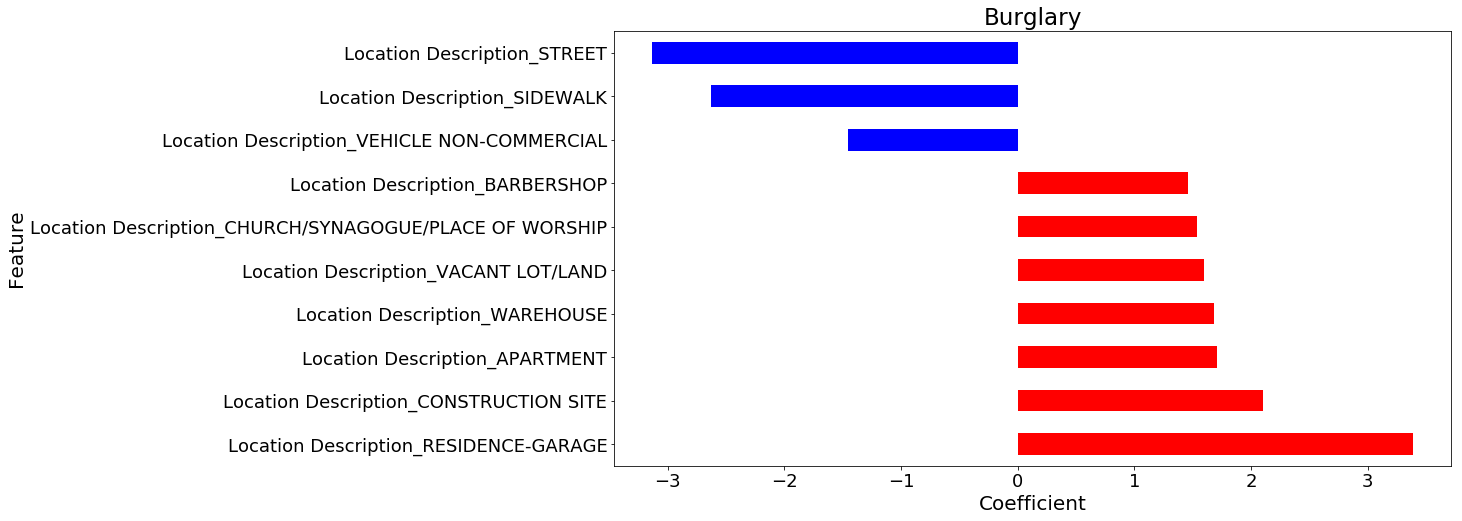

In [21]:
# Getting top 10 coefficients for burglary
imp_bur = pd.DataFrame(imp_df.loc['BURGLARY', :])
imp_bur['Magnitude'] = abs(imp_bur['BURGLARY'])
imp_bur.columns = ['Coefficient', 'Magnitude']
imp_bur['Positive'] = imp_bur['Coefficient'] > 0

imp_bur = imp_bur.sort_values(by='Magnitude', ascending=False)[:10]
imp_bur = imp_bur.sort_values(by='Coefficient', ascending=False)

# Barplot
imp_bur.plot.barh(y='Coefficient', figsize = (15,8), legend=False, color=imp_bur['Positive'].map({True: 'r', False: 'b'}))
plt.title('Burglary', size=23)
_ = plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)
plt.ylabel('Feature', size=20)
plt.xlabel('Coefficient', size=20)
#plt.savefig('../Figures/burglary.jpg', bbox_inches='tight')

Text(0.5,0,'Coefficient')

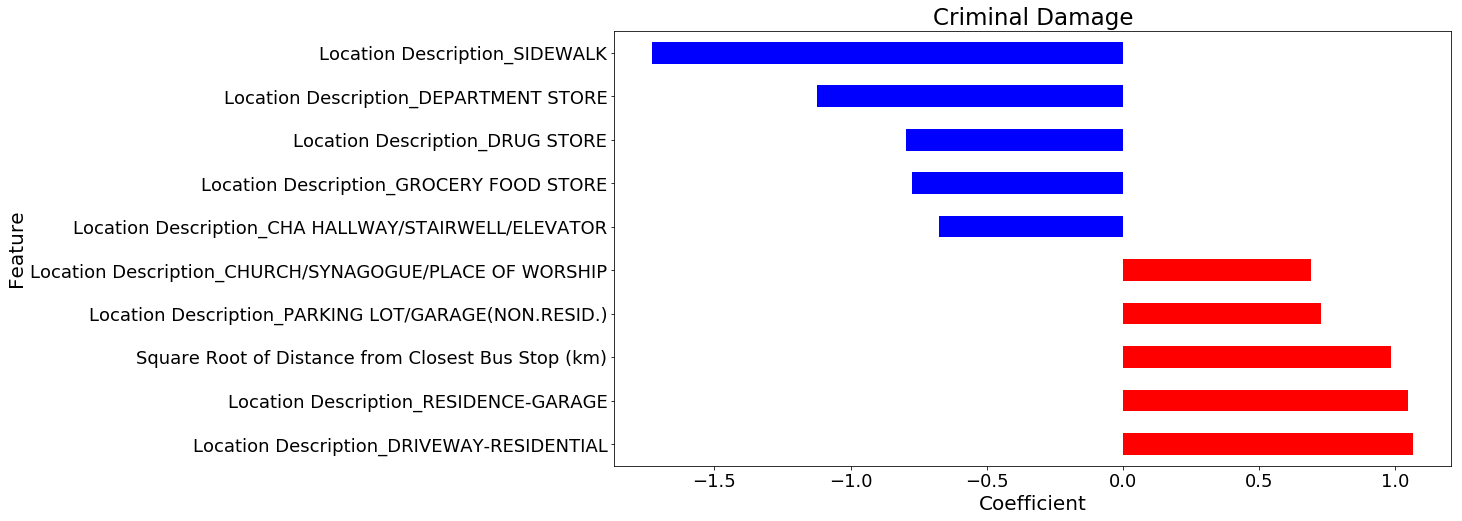

In [22]:
# Getting top 10 coefficients for criminal damage
imp_dam = pd.DataFrame(imp_df.loc['CRIMINAL DAMAGE', :])
imp_dam['Magnitude'] = abs(imp_dam['CRIMINAL DAMAGE'])
imp_dam.columns = ['Coefficient', 'Magnitude']
imp_dam['Positive'] = imp_dam['Coefficient'] > 0

imp_dam = imp_dam.sort_values(by='Magnitude', ascending=False)[:10]
imp_dam = imp_dam.sort_values(by='Coefficient', ascending=False)

# Barplot
imp_dam.plot.barh(y='Coefficient', figsize = (15,8), legend=False, color=imp_dam['Positive'].map({True: 'r', False: 'b'}))
plt.title('Criminal Damage', size=23)
_ = plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)
plt.ylabel('Feature', size=20)
plt.xlabel('Coefficient', size=20)
#plt.savefig('../Figures/criminal_damage.jpg', bbox_inches='tight')

Text(0.5,0,'Coefficient')

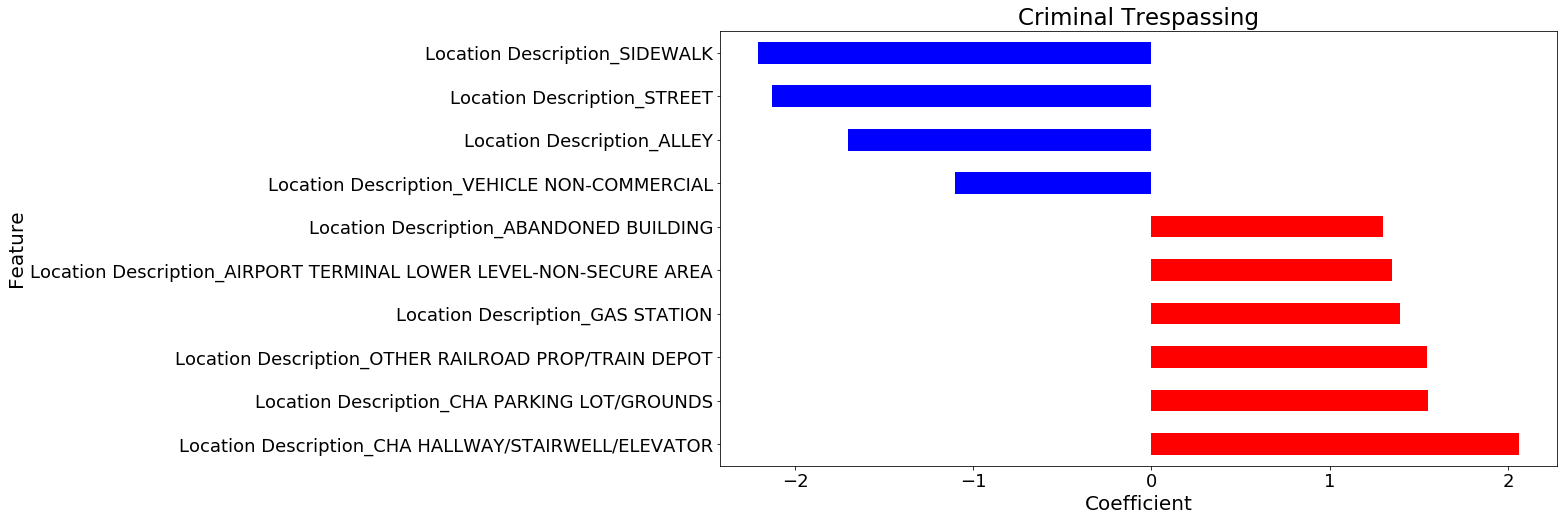

In [23]:
# Getting top 10 coefficients for criminal trespassing
imp_tres = pd.DataFrame(imp_df.loc['CRIMINAL TRESPASS', :])
imp_tres['Magnitude'] = abs(imp_tres['CRIMINAL TRESPASS'])
imp_tres.columns = ['Coefficient', 'Magnitude']
imp_tres['Positive'] = imp_tres['Coefficient'] > 0

imp_tres = imp_tres.sort_values(by='Magnitude', ascending=False)[:10]
imp_tres = imp_tres.sort_values(by='Coefficient', ascending=False)

# Barplot
imp_tres.plot.barh(y='Coefficient', figsize = (15,8), legend=False, color=imp_tres['Positive'].map({True: 'r', False: 'b'}))
plt.title('Criminal Trespassing', size=23)
_ = plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)
plt.ylabel('Feature', size=20)
plt.xlabel('Coefficient', size=20)
#plt.savefig('../Figures/criminal_trespass.jpg', bbox_inches='tight')

Text(0.5,1,'Deceptive Practice')

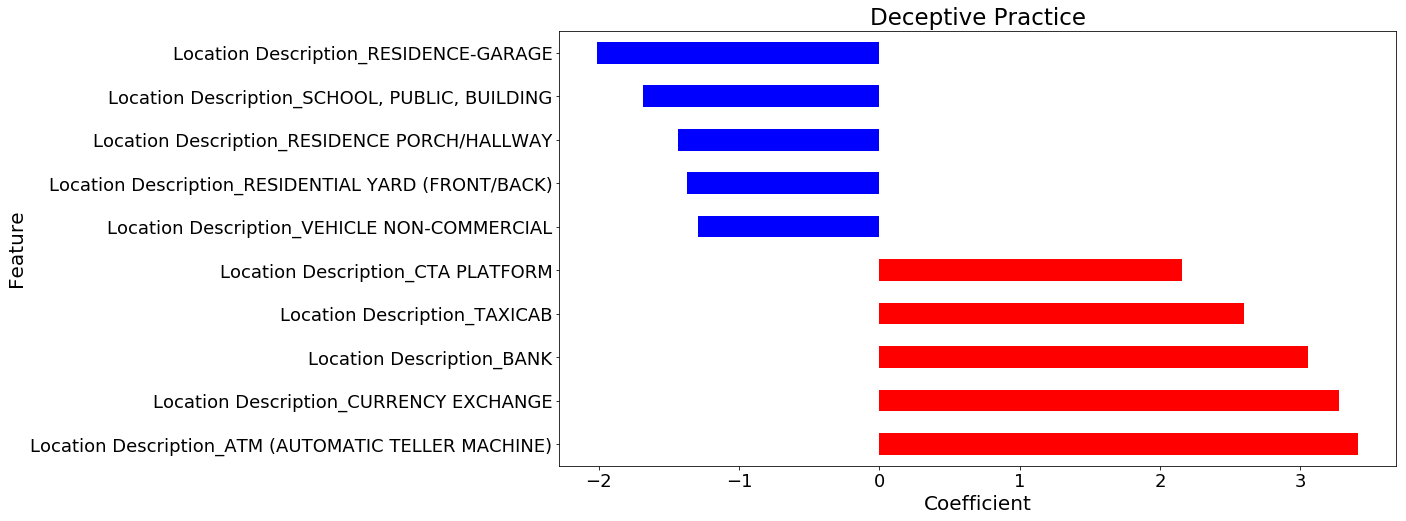

In [24]:
# Getting top 10 coefficients for deceptive practice
imp_dec = pd.DataFrame(imp_df.loc['DECEPTIVE PRACTICE', :])
imp_dec['Magnitude'] = abs(imp_dec['DECEPTIVE PRACTICE'])
imp_dec.columns = ['Coefficient', 'Magnitude']
imp_dec['Positive'] = imp_dec['Coefficient'] > 0

imp_dec = imp_dec.sort_values(by='Magnitude', ascending=False)[:10]
imp_dec = imp_dec.sort_values(by='Coefficient', ascending=False)

# Barplot
imp_dec.plot.barh(y='Coefficient', figsize = (15,8), legend=False, color=imp_dec['Positive'].map({True: 'r', False: 'b'}))
_ = plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)
plt.ylabel('Feature', size=20)
plt.xlabel('Coefficient', size=20)
plt.title('Deceptive Practice', size=23)
#plt.savefig('../Figures/deceptive_practice.jpg', bbox_inches='tight')

Text(0.5,1,'Motor Vehicle Theft')

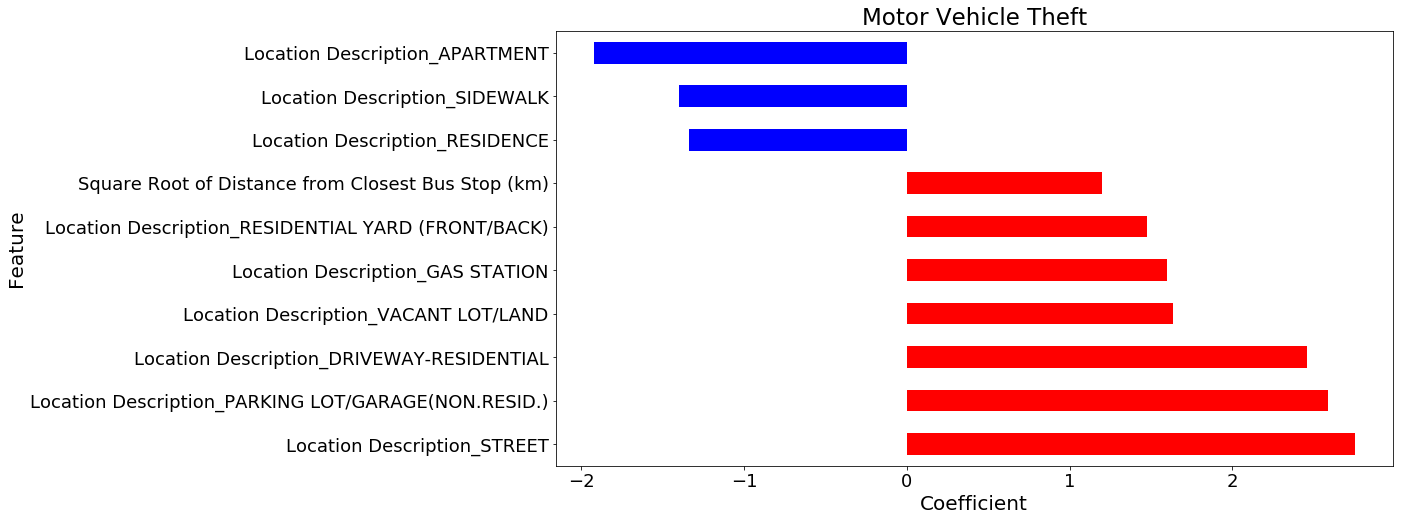

In [25]:
# Getting top 10 coefficients for motor vehicle theft
imp_mot = pd.DataFrame(imp_df.loc['MOTOR VEHICLE THEFT', :])
imp_mot['Magnitude'] = abs(imp_mot['MOTOR VEHICLE THEFT'])
imp_mot.columns = ['Coefficient', 'Magnitude']
imp_mot['Positive'] = imp_mot['Coefficient'] > 0

imp_mot = imp_mot.sort_values(by='Magnitude', ascending=False)[:10]
imp_mot = imp_mot.sort_values(by='Coefficient', ascending=False)

# Barplot
imp_mot.plot.barh(y='Coefficient', figsize = (15,8), legend=False, color=imp_mot['Positive'].map({True: 'r', False: 'b'}))
_ = plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)
plt.ylabel('Feature', size=20)
plt.xlabel('Coefficient', size=20)
plt.title('Motor Vehicle Theft', size=23)
#plt.savefig('../Figures/motor_vehicle_theft.jpg', bbox_inches='tight')

Text(0.5,0,'Coefficient')

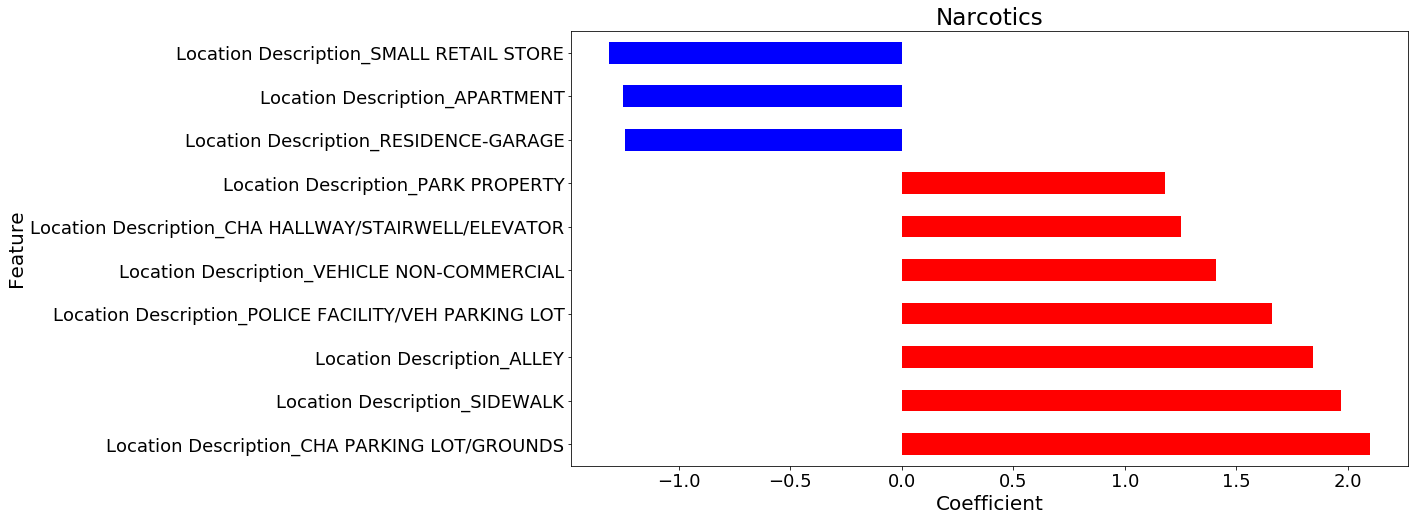

In [26]:
# Getting top 10 coefficients for narcotics
imp_nar = pd.DataFrame(imp_df.loc['NARCOTICS', :])
imp_nar['Magnitude'] = abs(imp_nar['NARCOTICS'])
imp_nar.columns = ['Coefficient', 'Magnitude']
imp_nar['Positive'] = imp_nar['Coefficient'] > 0

imp_nar = imp_nar.sort_values(by='Magnitude', ascending=False)[:10]
imp_nar = imp_nar.sort_values(by='Coefficient', ascending=False)

# Barplot
imp_nar.plot.barh(y='Coefficient', figsize = (15,8), legend=False, color=imp_nar['Positive'].map({True: 'r', False: 'b'}))
plt.title('Narcotics', size=23)
_ = plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)
plt.ylabel('Feature', size=20)
plt.xlabel('Coefficient', size=20)
#plt.savefig('../Figures/narcotics.jpg', bbox_inches='tight')

Text(0.5,0,'Coefficient')

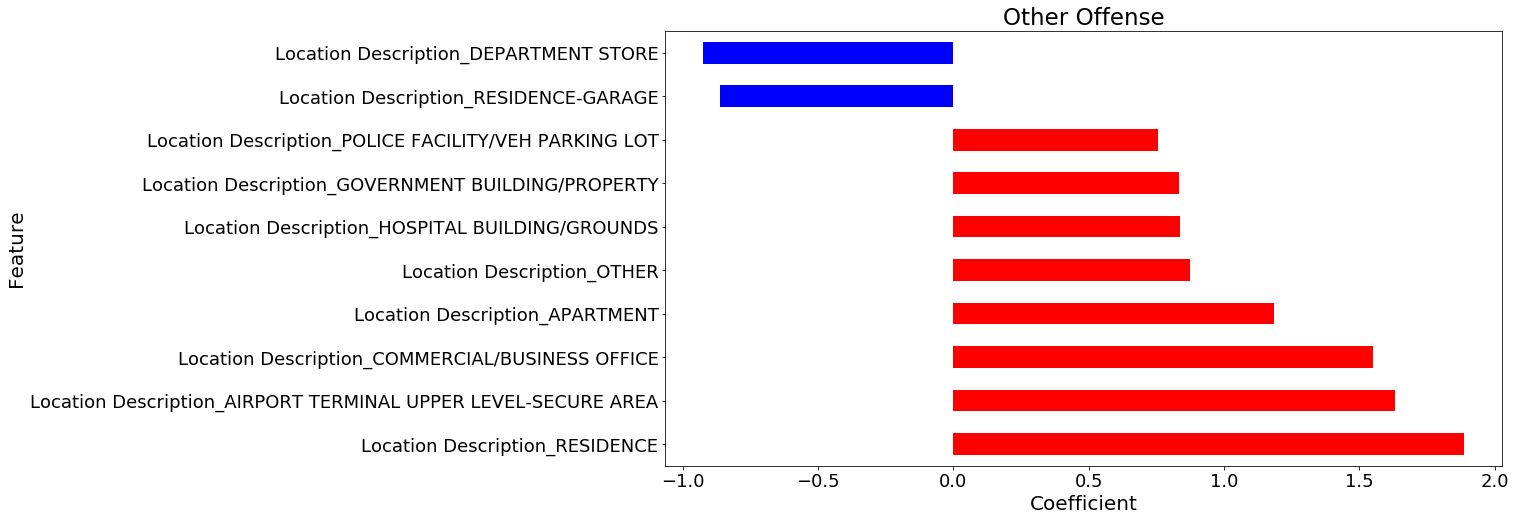

In [27]:
# Getting top 10 coefficients for other offenses
imp_oth = pd.DataFrame(imp_df.loc['OTHER OFFENSE', :])
imp_oth['Magnitude'] = abs(imp_oth['OTHER OFFENSE'])
imp_oth.columns = ['Coefficient', 'Magnitude']
imp_oth['Positive'] = imp_oth['Coefficient'] > 0

imp_oth = imp_oth.sort_values(by='Magnitude', ascending=False)[:10]
imp_oth = imp_oth.sort_values(by='Coefficient', ascending=False)

# Barplot
imp_oth.plot.barh(y='Coefficient', figsize = (15,8), legend=False, color=imp_oth['Positive'].map({True: 'r', False: 'b'}))
plt.title('Other Offense', size=23)
_ = plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)
plt.ylabel('Feature', size=20)
plt.xlabel('Coefficient', size=20)
#plt.savefig('../Figures/other_offense.jpg', bbox_inches='tight')

Text(0.5,1,'Robbery')

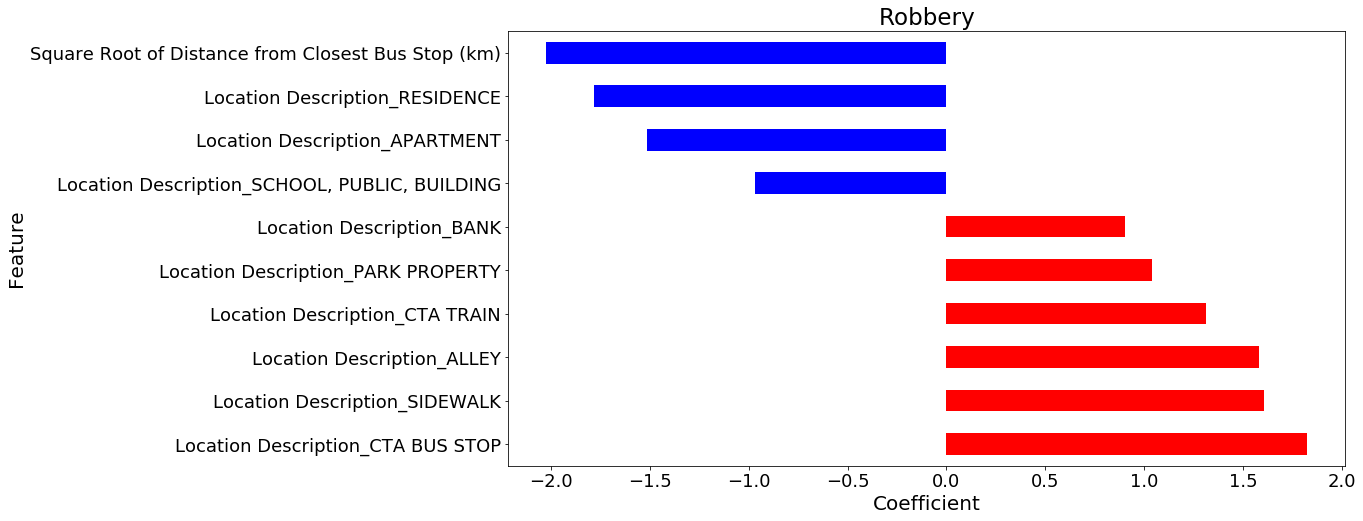

In [28]:
# Getting top 10 coefficients for robbery
imp_rob = pd.DataFrame(imp_df.loc['ROBBERY', :])
imp_rob['Magnitude'] = abs(imp_rob['ROBBERY'])
imp_rob.columns = ['Coefficient', 'Magnitude']
imp_rob['Positive'] = imp_rob['Coefficient'] > 0

imp_rob = imp_rob.sort_values(by='Magnitude', ascending=False)[:10]
imp_rob = imp_rob.sort_values(by='Coefficient', ascending=False)

# Barplot
imp_rob.plot.barh(y='Coefficient', figsize = (15,8), legend=False, color=imp_rob['Positive'].map({True: 'r', False: 'b'}))
_ = plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)
plt.ylabel('Feature', size=20)
plt.xlabel('Coefficient', size=20)
plt.title('Robbery', size=23)
#plt.savefig('../Figures/robbery.jpg', bbox_inches='tight')

Text(0.5,0,'Coefficient')

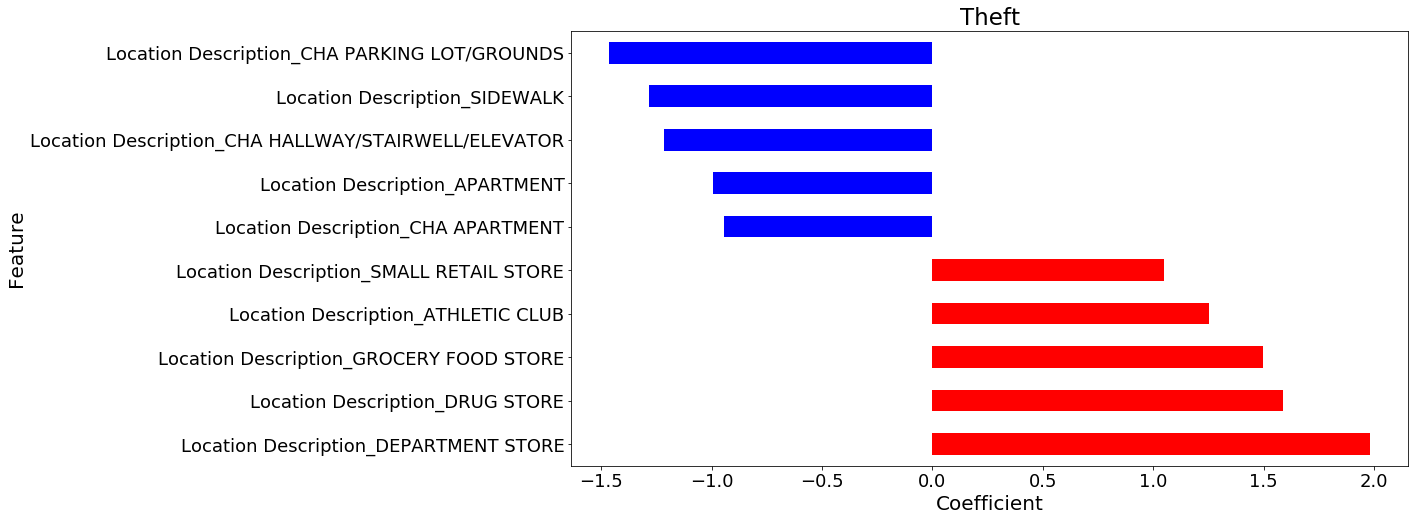

In [29]:
# Getting top 10 coefficients for theft
imp_theft = pd.DataFrame(imp_df.loc['THEFT', :])
imp_theft['Magnitude'] = abs(imp_theft['THEFT'])
imp_theft.columns = ['Coefficient', 'Magnitude']
imp_theft['Positive'] = imp_theft['Coefficient'] > 0

imp_theft = imp_theft.sort_values(by='Magnitude', ascending=False)[:10]
imp_theft = imp_theft.sort_values(by='Coefficient', ascending=False)

# Barplot
imp_theft.plot.barh(y='Coefficient', figsize = (15,8), legend=False, color=imp_theft['Positive'].map({True: 'r', False: 'b'}))
plt.title('Theft', size=23)
_ = plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)
plt.ylabel('Feature', size=20)
plt.xlabel('Coefficient', size=20)
#plt.savefig('../Figures/theft.jpg', bbox_inches='tight')

In [30]:
# Getting the average coefficient for each feature across all crime types
ave_coeff = []
for c in imp_df.columns:
    ave = np.mean(imp_df[c])
    ave_coeff.append(ave)

In [33]:
ave_coeff[:10], len(ave_coeff)

([0.35008069931975877,
  0.26462175500655827,
  -0.03866858534658027,
  -0.01861994845297844,
  0.2949684136760789,
  0.03716720258551161,
  -0.09626428121743266,
  0.15677928070346606,
  -0.010285034861651996,
  0.01329787186836849],
 652)

In [41]:
# Creating a dataframe out of the average coefficients
imp_df2 = pd.DataFrame({'Coefficient': ave_coeff})
imp_df2.index = imp_df.columns
imp_df2['Magnitude'] = abs(imp_df2['Coefficient'])
imp_df2 = imp_df2.sort_values(by='Magnitude', ascending=False)
imp_df2.head()

,Coefficient,Magnitude
Location Description_DEPARTMENT STORE,-0.561916,0.561916
Location Description_SIDEWALK,-0.560214,0.560214
Location Description_RESIDENCE-GARAGE,-0.465739,0.465739
Is Holiday_True,0.408527,0.408527
Day Type_WEEKDAY,0.387895,0.387895


Text(0.5,0,'Average Coefficient')

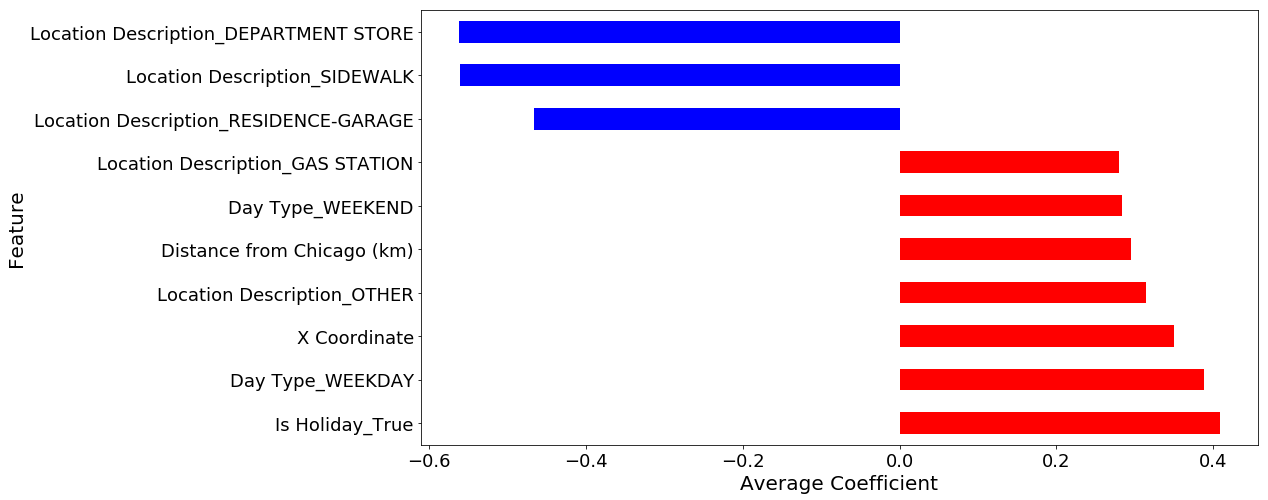

In [42]:
# Plotting bar chart of coefficients with highest magnitudes
imp_df2['Positive'] = imp_df2['Coefficient'] > 0
imp_df3 = imp_df2.sort_values(by='Magnitude', ascending=False)[:10]
imp_df3 = imp_df3.sort_values(by='Coefficient', ascending=False)
imp_df3.plot.barh(y='Coefficient', figsize = (15,8), legend=False, color=imp_df3['Positive'].map({True: 'r', False: 'b'}))
_ = plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)
plt.ylabel('Feature', size=20)
plt.xlabel('Average Coefficient', size=20)
#plt.savefig('../Figures/top_ten_features.jpg', bbox_inches='tight')

In [73]:
# Saving df to file
imp_df.to_csv('feature_coef_sgd.csv')

In [43]:
imp_df2.head()

,Coefficient,Magnitude,Positive
Location Description_DEPARTMENT STORE,-0.561916,0.561916,False
Location Description_SIDEWALK,-0.560214,0.560214,False
Location Description_RESIDENCE-GARAGE,-0.465739,0.465739,False
Is Holiday_True,0.408527,0.408527,True
Day Type_WEEKDAY,0.387895,0.387895,True


In [44]:
imp_df2.index

Index(['Location Description_DEPARTMENT STORE',
       'Location Description_SIDEWALK',
       'Location Description_RESIDENCE-GARAGE', 'Is Holiday_True',
       'Day Type_WEEKDAY', 'X Coordinate', 'Location Description_OTHER',
       'Distance from Chicago (km)', 'Day Type_WEEKEND',
       'Location Description_GAS STATION',
       ...
       'Location Description_VEHICLE-COMMERCIAL-TROLLEY BUS', 'Beat_825',
       'Location Description_AIRPORT TERMINAL MEZZANINE-NON-SECURE AREA',
       'Beat_934', 'Beat_512', 'Beat_430',
       'Location Description_VEHICLE-COMMERCIAL-ENTERTAINMENT/PARTY BUS',
       'Hour_22', 'Beat_331', 'Location Description_HORSE STABLE'],
      dtype='object', length=652)

In [45]:
# Getting the average coefficient for each feature across all dummy variables
features = X_sample.columns
ave_coef = []

for f in features:
    cols = [c for c in X_dummy_sample.columns if c.startswith(f)]
    coefs = []
    for col in cols:
        coefs.append(imp_df2.loc[col, 'Coefficient'])
    ave_coef.append([f, np.mean(coefs)])

In [46]:
# Creating dataframe out of average coefficients
imp_df4 = pd.DataFrame(ave_coef)
imp_df4.columns = ['Feature', 'Ave Coef']
imp_df4['Ave Mag'] = abs(imp_df4['Ave Coef'])
imp_df4 = imp_df4.sort_values(by='Ave Mag', ascending=False)
imp_df4.index = imp_df4['Feature']
imp_df4.head(10)

,Feature,Ave Coef,Ave Mag
Feature,,,
X Coordinate,X Coordinate,0.350081,0.350081
Day Type,Day Type,0.335645,0.335645
Is Holiday,Is Holiday,0.335645,0.335645
Distance from Chicago (km),Distance from Chicago (km),0.294968,0.294968
Y Coordinate,Y Coordinate,0.264622,0.264622
Season,Season,0.167823,0.167823
Time of Day,Time of Day,0.167823,0.167823
Square Root of Distance from Closest Bus Stop (km),Square Root of Distance from Closest Bus Stop ...,-0.096264,0.096264
Day of the Week,Day of the Week,0.095899,0.095899


Text(0.5,0,'Average Coefficient')

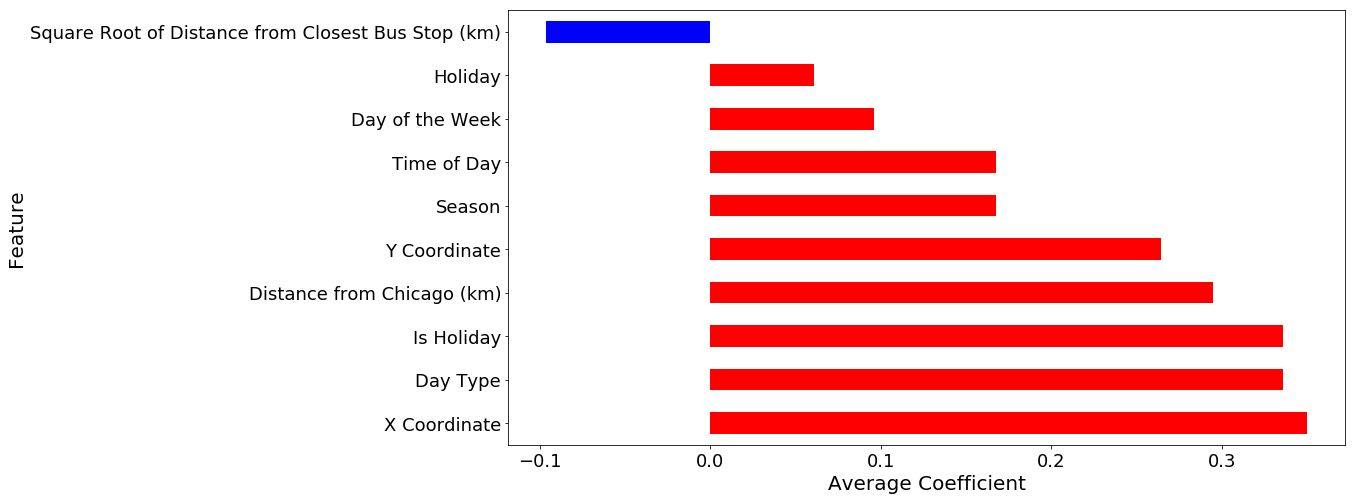

In [47]:
# Getting top 10 average coefficients for each feature across all crime types and dummy variables
imp_df4['Positive'] = imp_df4['Ave Coef'] > 0
imp_df4 = imp_df4.sort_values(by='Ave Mag', ascending=False)[:10]
imp_df4 = imp_df4.sort_values(by='Ave Coef', ascending=False)

# Making Barplot
imp_df4.plot.barh(y='Ave Coef', figsize = (15,8), legend=False, color=imp_df4['Positive'].map({True: 'r', False: 'b'}))
_ = plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)
plt.ylabel('Feature', size=20)
plt.xlabel('Average Coefficient', size=20)
#plt.savefig('../Figures/ave_mag_coeff_sgd_alldummy.jpg', bbox_inches='tight')

In [48]:
imp_df4.to_csv('ave_coef_mag_sgd.csv', index=False)